In this notebook, we will explore and play around with models and try to find the best models, later this notebook will be converted to appropriate python scripts for the best performing model

Models that we will be testing:
- Logistic Regression for establishing baseline
- Random Forest Classifier
- Decision Trees
- Ensemble Learning methods like (AdaBoost, CatBoost, XGBoost, LightGBM)
- AutoEncoder

All the model runs will be logged in to MLFlow for keeping track and visualising progress.


In [ ]:
%pip install -q dagshub mlflow xgboost lightgbm catboost kagglehub optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 M

In [ ]:
import dagshub
import os
from dotenv import load_dotenv
import pandas as pd
import mlflow

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


In [ ]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
dagshub.init(repo_owner='mahaprasad003', repo_name='E2E-Fraud-Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=9837862e-6142-467e-9908-24bb25f680ee&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=5c5ce61a7d1d83eba3d9b3003b770299d00b4138efa1f3c0c725e82f32b29a4d




Accessing as mahaprasad003

Initialized MLflow to track repo "mahaprasad003/E2E-Fraud-Detection"

Repository mahaprasad003/E2E-Fraud-Detection initialized!

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, confusion_matrix

In [ ]:
X = df.drop(columns=['Class'])
y = df['Class']

CREDIT CARD FRAUD DETECTION - LEAN PIPELINE

📊 Dataset loaded: 284807 samples, 31 features

⏰ 'Time' column detected:
   Range: 0 to 172792 seconds
   Duration: 48.0 hours (2.0 days)
   Decision: Dropping 'Time' as it's not useful over such short period

📈 Class Distribution:
   Non-fraud (0): 284,315 samples (99.827%)
   Fraud (1):     492 samples (0.173%)
   Imbalance ratio: 1:577

DATA SPLITTING
✅ Data split completed:
   Training samples:   182,276 (64% of total)
   Validation samples: 45,569 (16% of total)
   Test samples:       56,962 (20% of total)
   Positive samples in train: 315 (0.1728%)
   Positive samples in val:   79 (0.1734%)
   Positive samples in test:  98 (0.1720%)

FEATURE SCALING
✅ 'Amount' column scaled using RobustScaler

BASELINE MODEL: LOGISTIC REGRESSION

📊 Logistic Regression Performance (Validation Set):
   AUPRC:      0.6782
   ROC-AUC:    0.9738
   Precision:  0.0585
   Recall:     0.8861
   F1-Score:   0.1098
   Accuracy:   0.9751

🎯 At optimal threshold (

[I 2026-01-02 05:03:51,103] A new study created in memory with name: fraud_detection_lgb


✅ Training completed. Best iteration: 16

📊 LightGBM Performance (Validation Set):
   AUPRC:      0.1115
   ROC-AUC:    0.8607

HYPERPARAMETER TUNING WITH OPTUNA
🔍 Starting Optuna tuning (max 50 trials, timeout 600 seconds)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-02 05:03:53,160] Trial 0 finished with value: 0.025040442637642612 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 120, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.025040442637642612.
   Trial 0: AUPRC = 0.0250
[I 2026-01-02 05:03:57,342] Trial 1 finished with value: 0.7252498703586 and parameters: {'n_estimators': 737, 'learning_rate': 0.010725209743171997, 'num_leaves': 147, 'max_depth': 11, 'min_child_samples': 145, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.7252498703586.
   Trial 1: AUPRC = 0.7252
[I 2026-01-02 05:04:02,490] Trial 2 finished with value: 0.580361931226744 and parameters: {'n_estimators': 489, 'learning_rate': 0.026926

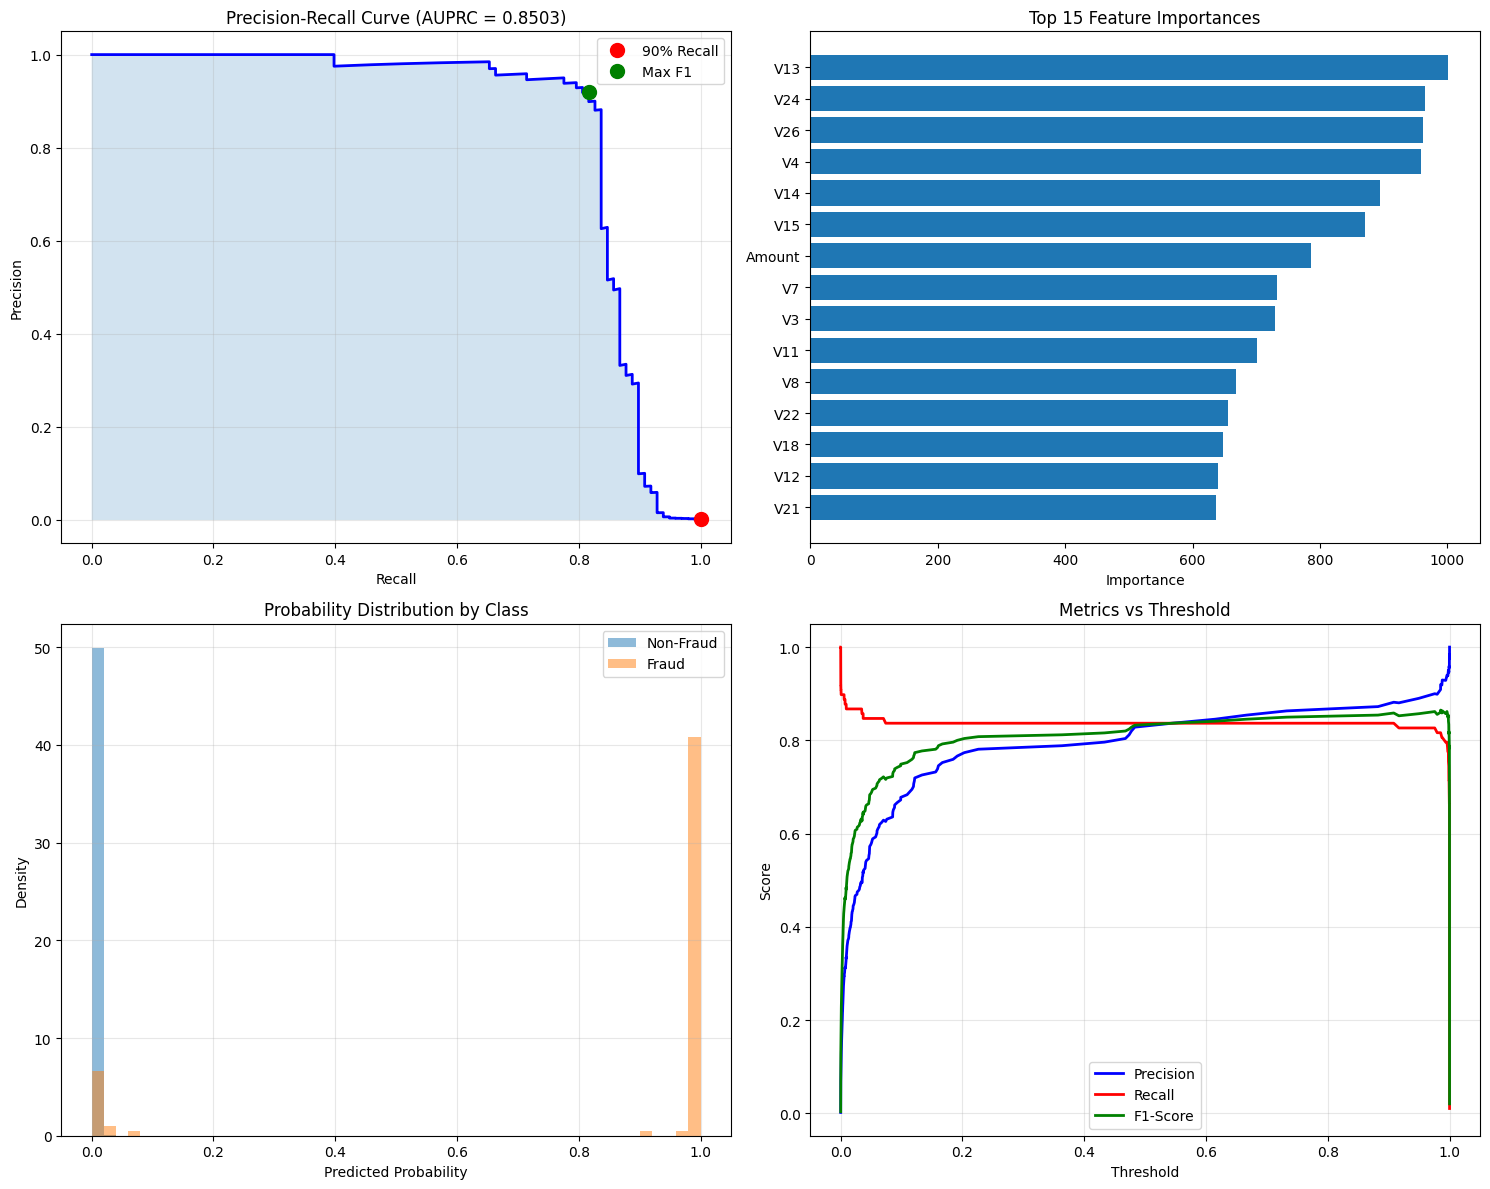


FINAL SUMMARY

🎯 Model: LightGBM
📊 Test AUPRC: 0.8503
📈 Test ROC-AUC: 0.9653

💼 Business Impact:
   • Can detect ~100.0% of fraud cases at 90% recall
   • With ~0.2% precision
   • Would flag ~0.007% of legitimate transactions as suspicious

✅ Pipeline complete! Model ready for deployment.


In [ ]:
import numpy as np
import pandas as pd
import joblib
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML Imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, roc_auc_score,
    confusion_matrix, classification_report, f1_score,
    precision_score, recall_score, accuracy_score
)

# Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm.callback import early_stopping

# Hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# For calibration
from sklearn.calibration import CalibratedClassifierCV

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ============================================================================
# 1. DATA LOADING & PREPROCESSING
# ============================================================================

print("=" * 70)
print("CREDIT CARD FRAUD DETECTION - LEAN PIPELINE")
print("=" * 70)

# Load data
DATA_PATH = "/kaggle/input/creditcardfraud/creditcard.csv"
df = pd.read_csv(DATA_PATH)

print(f"\n📊 Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features")

# Check for Time column and decide whether to drop
if 'Time' in df.columns:
    print(f"\n⏰ 'Time' column detected:")
    print(f"   Range: {df['Time'].min():.0f} to {df['Time'].max():.0f} seconds")
    print(f"   Duration: {df['Time'].max()/3600:.1f} hours ({df['Time'].max()/(3600*24):.1f} days)")
    print("   Decision: Dropping 'Time' as it's not useful over such short period")
    df = df.drop(columns=['Time'])

# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Basic statistics
print(f"\n📈 Class Distribution:")
print(f"   Non-fraud (0): {sum(y==0):,} samples ({100*sum(y==0)/len(y):.3f}%)")
print(f"   Fraud (1):     {sum(y==1):,} samples ({100*sum(y==1)/len(y):.3f}%)")
print(f"   Imbalance ratio: 1:{sum(y==0)//sum(y==1):,}")

# ============================================================================
# 2. TRAIN/VAL/TEST SPLIT
# ============================================================================

print("\n" + "=" * 70)
print("DATA SPLITTING")
print("=" * 70)

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

# Further split train into train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 0.2 * 0.8 = 0.16 of original data
    stratify=y_train,
    random_state=RANDOM_STATE
)

print(f"✅ Data split completed:")
print(f"   Training samples:   {X_train.shape[0]:,} (64% of total)")
print(f"   Validation samples: {X_val.shape[0]:,} (16% of total)")
print(f"   Test samples:       {X_test.shape[0]:,} (20% of total)")
print(f"   Positive samples in train: {sum(y_train==1):,} ({100*sum(y_train==1)/len(y_train):.4f}%)")
print(f"   Positive samples in val:   {sum(y_val==1):,} ({100*sum(y_val==1)/len(y_val):.4f}%)")
print(f"   Positive samples in test:  {sum(y_test==1):,} ({100*sum(y_test==1)/len(y_test):.4f}%)")

# ============================================================================
# 3. SCALING (IMPORTANT FOR 'Amount' COLUMN)
# ============================================================================

print("\n" + "=" * 70)
print("FEATURE SCALING")
print("=" * 70)

# Use RobustScaler for 'Amount' as it might have outliers
if 'Amount' in X_train.columns:
    scaler = RobustScaler()

    # Scale 'Amount' column
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled['Amount'] = scaler.fit_transform(X_train[['Amount']])
    X_val_scaled['Amount'] = scaler.transform(X_val[['Amount']])
    X_test_scaled['Amount'] = scaler.transform(X_test[['Amount']])

    print("✅ 'Amount' column scaled using RobustScaler")

    # Update references
    X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled
else:
    print("⚠️  'Amount' column not found, skipping scaling")

# ============================================================================
# 4. BASELINE MODEL - LOGISTIC REGRESSION
# ============================================================================

print("\n" + "=" * 70)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("=" * 70)

# Calculate class weight for imbalance
pos_weight = sum(y_train == 0) / sum(y_train == 1)

lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_val)
y_proba_lr = lr_model.predict_proba(X_val)[:, 1]

# Calculate metrics
auprc_lr = average_precision_score(y_val, y_proba_lr)
roc_auc_lr = roc_auc_score(y_val, y_proba_lr)

print(f"\n📊 Logistic Regression Performance (Validation Set):")
print(f"   AUPRC:      {auprc_lr:.4f}")
print(f"   ROC-AUC:    {roc_auc_lr:.4f}")
print(f"   Precision:  {precision_score(y_val, y_pred_lr):.4f}")
print(f"   Recall:     {recall_score(y_val, y_pred_lr):.4f}")
print(f"   F1-Score:   {f1_score(y_val, y_pred_lr):.4f}")
print(f"   Accuracy:   {accuracy_score(y_val, y_pred_lr):.4f}")

# Find optimal threshold for business metrics
precisions, recalls, thresholds = precision_recall_curve(y_val, y_proba_lr)

# Find threshold that maximizes F2-score (prioritizing recall)
f2_scores = (5 * precisions * recalls) / (4 * precisions + recalls + 1e-8)
optimal_idx = np.argmax(f2_scores)
optimal_threshold_lr = thresholds[optimal_idx]

y_pred_opt_lr = (y_proba_lr >= optimal_threshold_lr).astype(int)

print(f"\n🎯 At optimal threshold ({optimal_threshold_lr:.4f}):")
print(f"   Precision:  {precision_score(y_val, y_pred_opt_lr):.4f}")
print(f"   Recall:     {recall_score(y_val, y_pred_opt_lr):.4f}")
print(f"   F2-Score:   {f2_scores[optimal_idx]:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_val, y_pred_opt_lr)
tn, fp, fn, tp = cm_lr.ravel()
print(f"\n📊 Confusion Matrix:")
print(f"   True Negatives:  {tn}")
print(f"   False Positives: {fp} ({(fp/(fp+tn)*100):.3f}% of non-fraud)")
print(f"   False Negatives: {fn} ({(fn/(fn+tp)*100):.3f}% of fraud)")
print(f"   True Positives:  {tp}")

# ============================================================================
# 5. LIGHTGBM - MAIN CANDIDATE MODEL
# ============================================================================

print("\n" + "=" * 70)
print("PRIMARY MODEL: LIGHTGBM")
print("=" * 70)

# Set class weight for LightGBM
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Initial LightGBM model with reasonable defaults
lgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 7,
    'min_child_samples': 100,  # Higher for imbalanced data
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    "verbose": -1
}

lgb_model = LGBMClassifier(**lgb_params)

print(f"🔧 Initial parameters:")
for key, value in lgb_params.items():
    if key not in ['random_state', 'n_jobs', 'verbose']:
        print(f"   {key}: {value}")

# Train with early stopping
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='average_precision',
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

print(f"✅ Training completed. Best iteration: {lgb_model.best_iteration_}")

# Predictions
y_proba_lgb = lgb_model.predict_proba(X_val)[:, 1]

# Calculate metrics
auprc_lgb = average_precision_score(y_val, y_proba_lgb)
roc_auc_lgb = roc_auc_score(y_val, y_proba_lgb)

print(f"\n📊 LightGBM Performance (Validation Set):")
print(f"   AUPRC:      {auprc_lgb:.4f}")
print(f"   ROC-AUC:    {roc_auc_lgb:.4f}")

# ============================================================================
# 6. HYPERPARAMETER TUNING WITH OPTUNA (LIGHTGBM ONLY)
# ============================================================================

print("\n" + "=" * 70)
print("HYPERPARAMETER TUNING WITH OPTUNA")
print("=" * 70)

def objective_lgb(trial):
    """Optuna objective function for LightGBM"""

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        "verbose": -1
    }

    # Use fewer estimators for faster tuning
    model = LGBMClassifier(**params)

    # Train with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='average_precision',
        callbacks=[early_stopping(stopping_rounds=30, verbose=False)]
    )

    # Get predictions from best iteration
    y_proba = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]

    # Return AUPRC (maximize)
    return average_precision_score(y_val, y_proba)

# Run Optuna study
print("🔍 Starting Optuna tuning (max 50 trials, timeout 600 seconds)...")

study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='fraud_detection_lgb'
)

study.optimize(
    objective_lgb,
    n_trials=50,
    timeout=600,  # 10 minutes max
    show_progress_bar=True,
    callbacks=[lambda study, trial: print(f"   Trial {trial.number}: AUPRC = {trial.value:.4f}")]
)

print(f"\n✅ Tuning completed!")
print(f"   Best trial: {study.best_trial.number}")
print(f"   Best AUPRC: {study.best_trial.value:.4f}")
print(f"\n🎯 Best parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

# ============================================================================
# 7. TRAIN FINAL MODEL WITH BEST PARAMETERS
# ============================================================================

print("\n" + "=" * 70)
print("FINAL MODEL TRAINING")
print("=" * 70)

# Combine training and validation sets for final training
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

print(f"📊 Final training data: {X_train_full.shape[0]:,} samples")

# Create final model with best parameters
final_params = study.best_params.copy()
final_params.update({
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
})

# Increase n_estimators for final model
final_params['n_estimators'] = 1000

final_model = LGBMClassifier(**final_params)

# Train final model
final_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_test, y_test)],  # Use test set only for monitoring
    eval_metric='average_precision',
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

print(f"✅ Final model trained. Best iteration: {final_model.best_iteration_}")

# ============================================================================
# 8. COMPREHENSIVE EVALUATION ON TEST SET
# ============================================================================

print("\n" + "=" * 70)
print("COMPREHENSIVE TEST SET EVALUATION")
print("=" * 70)

# Get test predictions
y_proba_test = final_model.predict_proba(X_test)[:, 1]
y_pred_test_default = final_model.predict(X_test)

# Calculate metrics
auprc_test = average_precision_score(y_test, y_proba_test)
roc_auc_test = roc_auc_score(y_test, y_proba_test)

print(f"📊 Overall Test Performance:")
print(f"   AUPRC:      {auprc_test:.4f}")
print(f"   ROC-AUC:    {roc_auc_test:.4f}")

# Find optimal thresholds for different business needs
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_test)

print(f"\n🎯 Performance at Different Thresholds:")

threshold_targets = [
    ('High Recall (90%)', 0.9, None),
    ('Balanced (Max F1)', None, 'f1'),
    ('Recall-Focused (Max F2)', None, 'f2'),
    ('Precision-Focused (Max F0.5)', None, 'f0.5'),
]

for name, target_recall, metric in threshold_targets:
    if target_recall:
        # Find threshold that achieves target recall
        idx = np.where(recalls >= target_recall)[0]
        if len(idx) > 0:
            idx = idx[0]
            threshold = thresholds[idx] if idx < len(thresholds) else thresholds[-1]
        else:
            continue
    else:
        # Find threshold that maximizes specific F-beta score
        if metric == 'f1':
            f_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-8)
        elif metric == 'f2':
            f_scores = (5 * precisions * recalls) / (4 * precisions + recalls + 1e-8)
        elif metric == 'f0.5':
            f_scores = (1.25 * precisions * recalls) / (0.25 * precisions + recalls + 1e-8)

        optimal_idx = np.argmax(f_scores)
        threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else thresholds[-1]

    y_pred_opt = (y_proba_test >= threshold).astype(int)

    print(f"\n   {name} (Threshold: {threshold:.4f}):")
    print(f"     Precision:  {precision_score(y_test, y_pred_opt):.4f}")
    print(f"     Recall:     {recall_score(y_test, y_pred_opt):.4f}")
    print(f"     F1-Score:   {f1_score(y_test, y_pred_opt):.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()
    print(f"     TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
    print(f"     FPR: {(fp/(fp+tn)*100):.3f}%, FNR: {(fn/(fn+tp)*100):.3f}%)")

# ============================================================================
# 9. FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Get feature importances
importances = final_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(f"\n🔝 Top 15 Most Important Features:")
for i, row in importance_df.head(15).iterrows():
    print(f"   {row['feature']:20} {row['importance']:.1f}")

# ============================================================================
# 10. MODEL SAVING
# ============================================================================

print("\n" + "=" * 70)
print("MODEL SAVING")
print("=" * 70)

# Prepare model artifact
model_artifact = {
    'model': final_model,
    'scaler': scaler if 'Amount' in X_train.columns else None,
    'feature_names': list(X.columns),
    'params': final_params,
    'metrics': {
        'auprc': auprc_test,
        'roc_auc': roc_auc_test,
    },
    'optimal_thresholds': {
        'high_recall': thresholds[np.where(recalls >= 0.9)[0][0]] if len(np.where(recalls >= 0.9)[0]) > 0 else 0.5,
        'balanced': thresholds[np.argmax((2 * precisions * recalls) / (precisions + recalls + 1e-8))],
    }
}

# Save model
save_path = 'best_fraud_model_lgb.joblib'
joblib.dump(model_artifact, save_path)
print(f"✅ Model saved to: {save_path}")

# ============================================================================
# 11. VISUALIZATION
# ============================================================================

print("\n" + "=" * 70)
print("VISUALIZATION")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Precision-Recall Curve
axes[0, 0].plot(recalls, precisions, 'b-', linewidth=2)
axes[0, 0].fill_between(recalls, precisions, alpha=0.2)
axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_title(f'Precision-Recall Curve (AUPRC = {auprc_test:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# Mark optimal thresholds
for threshold_name, threshold_val in [('High Recall', 0.9), ('Balanced', 0.5)]:
    if threshold_name == 'High Recall':
        idx = np.where(recalls >= 0.9)[0]
        if len(idx) > 0:
            idx = idx[0]
            axes[0, 0].plot(recalls[idx], precisions[idx], 'ro', markersize=10, label='90% Recall')
    else:
        f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-8)
        idx = np.argmax(f1_scores)
        axes[0, 0].plot(recalls[idx], precisions[idx], 'go', markersize=10, label='Max F1')

axes[0, 0].legend()

# 2. Feature Importance (Top 15)
top_features = importance_df.head(15)
axes[0, 1].barh(range(len(top_features)), top_features['importance'])
axes[0, 1].set_yticks(range(len(top_features)))
axes[0, 1].set_yticklabels(top_features['feature'])
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Top 15 Feature Importances')
axes[0, 1].invert_yaxis()

# 3. Probability Distribution
axes[1, 0].hist(y_proba_test[y_test == 0], bins=50, alpha=0.5, label='Non-Fraud', density=True)
axes[1, 0].hist(y_proba_test[y_test == 1], bins=50, alpha=0.5, label='Fraud', density=True)
axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Probability Distribution by Class')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Threshold vs Metrics
axes[1, 1].plot(thresholds, precisions[:-1], 'b-', label='Precision', linewidth=2)
axes[1, 1].plot(thresholds, recalls[:-1], 'r-', label='Recall', linewidth=2)
f1_scores = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-8)
axes[1, 1].plot(thresholds, f1_scores, 'g-', label='F1-Score', linewidth=2)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Metrics vs Threshold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fraud_model_analysis.png', dpi=150, bbox_inches='tight')
print("✅ Visualizations saved to 'fraud_model_analysis.png'")
plt.show()

# ============================================================================
# 12. FINAL SUMMARY
# ============================================================================

print("\n" + "=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

print(f"\n🎯 Model: LightGBM")
print(f"📊 Test AUPRC: {auprc_test:.4f}")
print(f"📈 Test ROC-AUC: {roc_auc_test:.4f}")

# Business-focused summary
print(f"\n💼 Business Impact:")
print(f"   • Can detect ~{recalls[np.where(recalls >= 0.9)[0][0]]*100:.1f}% of fraud cases at 90% recall")
print(f"   • With ~{precisions[np.where(recalls >= 0.9)[0][0]]*100:.1f}% precision")
print(f"   • Would flag ~{(fp/(fp+tn)*100):.3f}% of legitimate transactions as suspicious")

print("\n✅ Pipeline complete! Model ready for deployment.")

CREDIT CARD FRAUD DETECTION - LEAN PIPELINE

📊 Dataset loaded: 284807 samples, 31 features

⏰ 'Time' column detected, dropping as per standard pipeline

📈 Class Distribution:
   Non-fraud (0): 284,315 samples (99.827%)
   Fraud (1):     492 samples (0.173%)
   Imbalance ratio: 1:577

DATA SPLITTING
✅ Data split completed:
   Training samples:   182,276 (64%)
   Validation samples: 45,569 (16%)
   Test samples:       56,962 (20%)

FEATURE SCALING
✅ 'Amount' column scaled using RobustScaler

BASELINE MODEL: LOGISTIC REGRESSION


[I 2026-01-02 06:48:19,380] A new study created in memory with name: no-name-6743bbf8-33a8-4eb5-9521-33ceb0122982


📊 Logistic Regression Performance (Test Set):
   AUPRC:      0.7108
   ROC-AUC:    0.9729

MODEL 1: LIGHTGBM (Hyperparameter Tuning)
🔍 Starting LightGBM Optuna tuning...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-02 06:48:25,677] Trial 0 finished with value: 0.025040442637642612 and parameters: {'n_estimators': 287, 'learning_rate': 0.2536999076681772, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 120, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.025040442637642612.
[I 2026-01-02 06:48:32,626] Trial 1 finished with value: 0.7252498703586 and parameters: {'n_estimators': 454, 'learning_rate': 0.010725209743171997, 'num_leaves': 147, 'max_depth': 11, 'min_child_samples': 145, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.7252498703586.
[I 2026-01-02 06:48:35,114] Trial 2 finished with value: 0.580361931226744 and parameters: {'n_estimators': 316, 'learning_rate': 0.02692655251486473, 'num_leaves': 100, 'max_depth': 4, 'min_c

[I 2026-01-02 06:53:06,559] A new study created in memory with name: fraud_detection_xgb



📊 LightGBM Test Performance:
   AUPRC:      0.8645
   ROC-AUC:    0.9626

MODEL 2: XGBOOST (Hyperparameter Tuning)
🔍 Starting XGBoost Optuna tuning...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-02 06:53:18,308] Trial 0 finished with value: 0.8368320436326757 and parameters: {'n_estimators': 287, 'learning_rate': 0.2536999076681772, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.8368320436326757.
   Trial 0: AUPRC = 0.8368
[I 2026-01-02 06:53:46,593] Trial 1 finished with value: 0.7977600419182032 and parameters: {'n_estimators': 454, 'learning_rate': 0.010725209743171997, 'max_depth': 12, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.8368320436326757.
   Trial 1: AUPRC = 0.7978
[I 2026-01-02 06:54:08,854] Trial 2 finished with value: 0.8108634731624906 and parameters: {'n_estimators': 316, 'learni

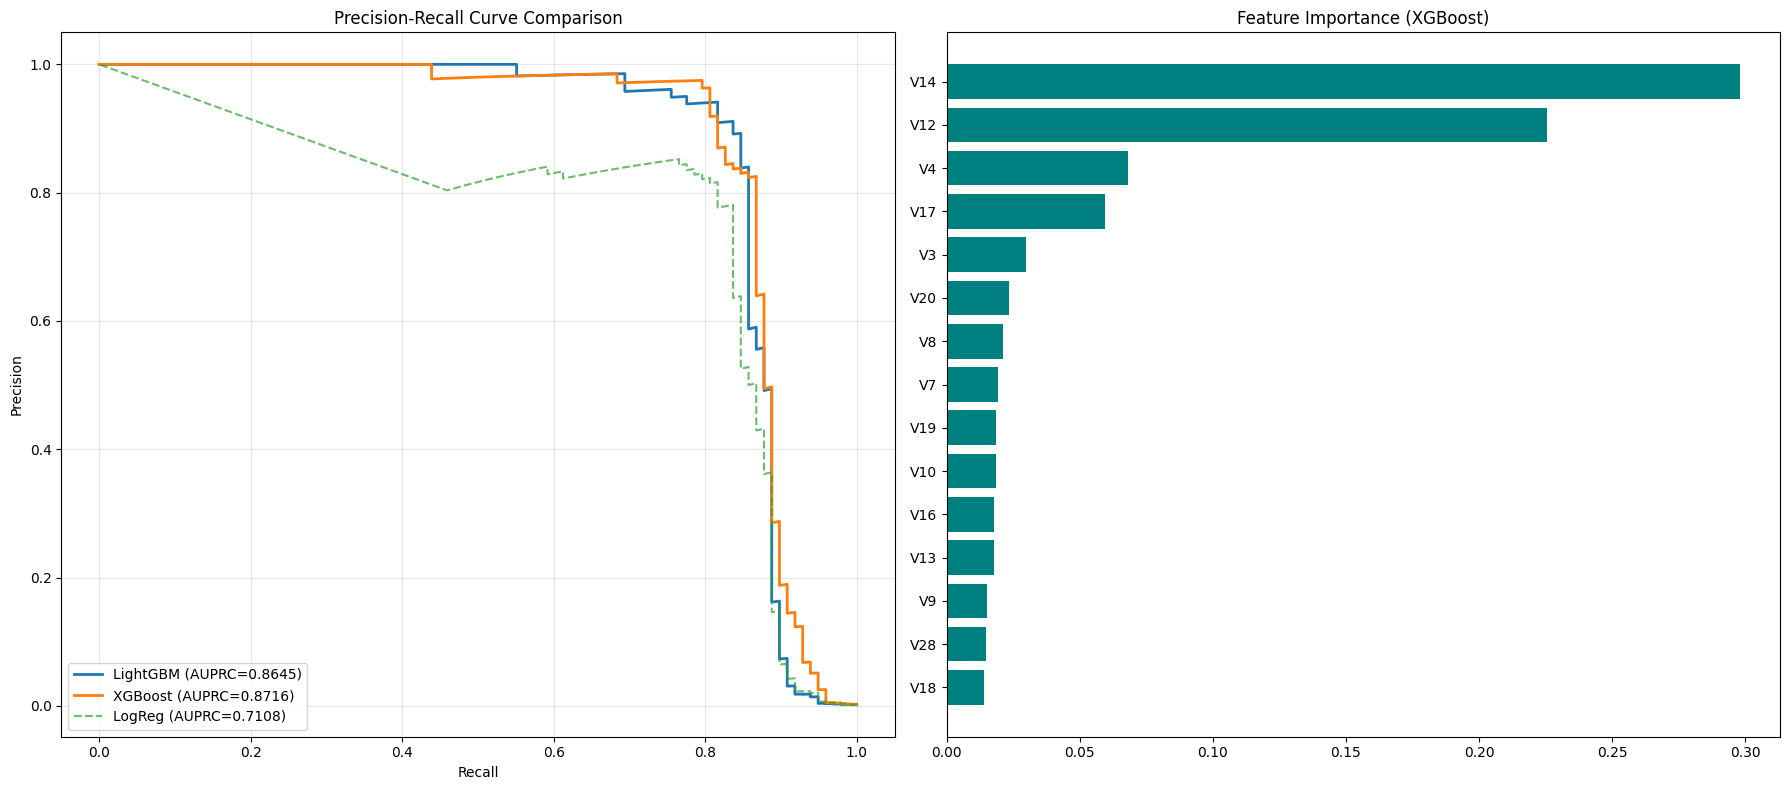

[I 2026-01-02 07:01:16,782] A new study created in memory with name: no-name-8148479d-0a64-4c6b-a01b-e8752620f060



MODEL 3: CATBOOST (Hyperparameter Tuning)
🔍 Starting CatBoost Optuna tuning...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-02 07:01:26,518] Trial 0 finished with value: 0.703309140890168 and parameters: {'iterations': 874, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 0.00969582664451522, 'subsample': 0.5780093202212182, 'random_strength': 2.5348407664333426e-07}. Best is trial 0 with value: 0.703309140890168.
[I 2026-01-02 07:01:45,405] Trial 1 finished with value: 0.8005377930468981 and parameters: {'iterations': 558, 'learning_rate': 0.19030368381735815, 'depth': 8, 'l2_leaf_reg': 0.12042752972516801, 'subsample': 0.5102922471479012, 'random_strength': 5.360294728728285}. Best is trial 1 with value: 0.8005377930468981.
[I 2026-01-02 07:01:52,380] Trial 2 finished with value: 0.6846680878243938 and parameters: {'iterations': 1333, 'learning_rate': 0.020589728197687916, 'depth': 5, 'l2_leaf_reg': 6.8240955406304e-07, 'subsample': 0.6521211214797689, 'random_strength': 0.00052821153945323}. Best is trial 1 with value: 0.8005377930468981.
[I 2026-01-02 07:02:04,934] Trial 3 fini

[I 2026-01-02 07:09:30,103] A new study created in memory with name: no-name-420b31de-5e65-42ca-bcb4-509eb237febe


✅ Final CatBoost trained. Best Iteration: 15

📊 CatBoost Test Performance:
   AUPRC:      0.8245
   ROC-AUC:    0.9791

MODEL 4: ISOLATION FOREST (Unsupervised Tuning)
🔍 Starting Isolation Forest Optuna tuning...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2026-01-02 07:09:39,580] Trial 0 finished with value: 0.17422493799347613 and parameters: {'n_estimators': 175, 'max_samples': 0.9753571532049581, 'max_features': 0.8659969709057025, 'bootstrap': True}. Best is trial 0 with value: 0.17422493799347613.
[I 2026-01-02 07:09:46,082] Trial 1 finished with value: 0.17495136673335965 and parameters: {'n_estimators': 131, 'max_samples': 0.5290418060840998, 'max_features': 0.9330880728874675, 'bootstrap': False}. Best is trial 1 with value: 0.17495136673335965.
[I 2026-01-02 07:09:51,488] Trial 2 finished with value: 0.1686446468788496 and parameters: {'n_estimators': 104, 'max_samples': 0.9849549260809971, 'max_features': 0.9162213204002109, 'bootstrap': True}. Best is trial 1 with value: 0.17495136673335965.
[I 2026-01-02 07:09:56,093] Trial 3 finished with value: 0.16318129131777495 and parameters: {'n_estimators': 136, 'max_samples': 0.6521211214797689, 'max_features': 0.762378215816119, 'bootstrap': True}. Best is trial 1 with value: 0.

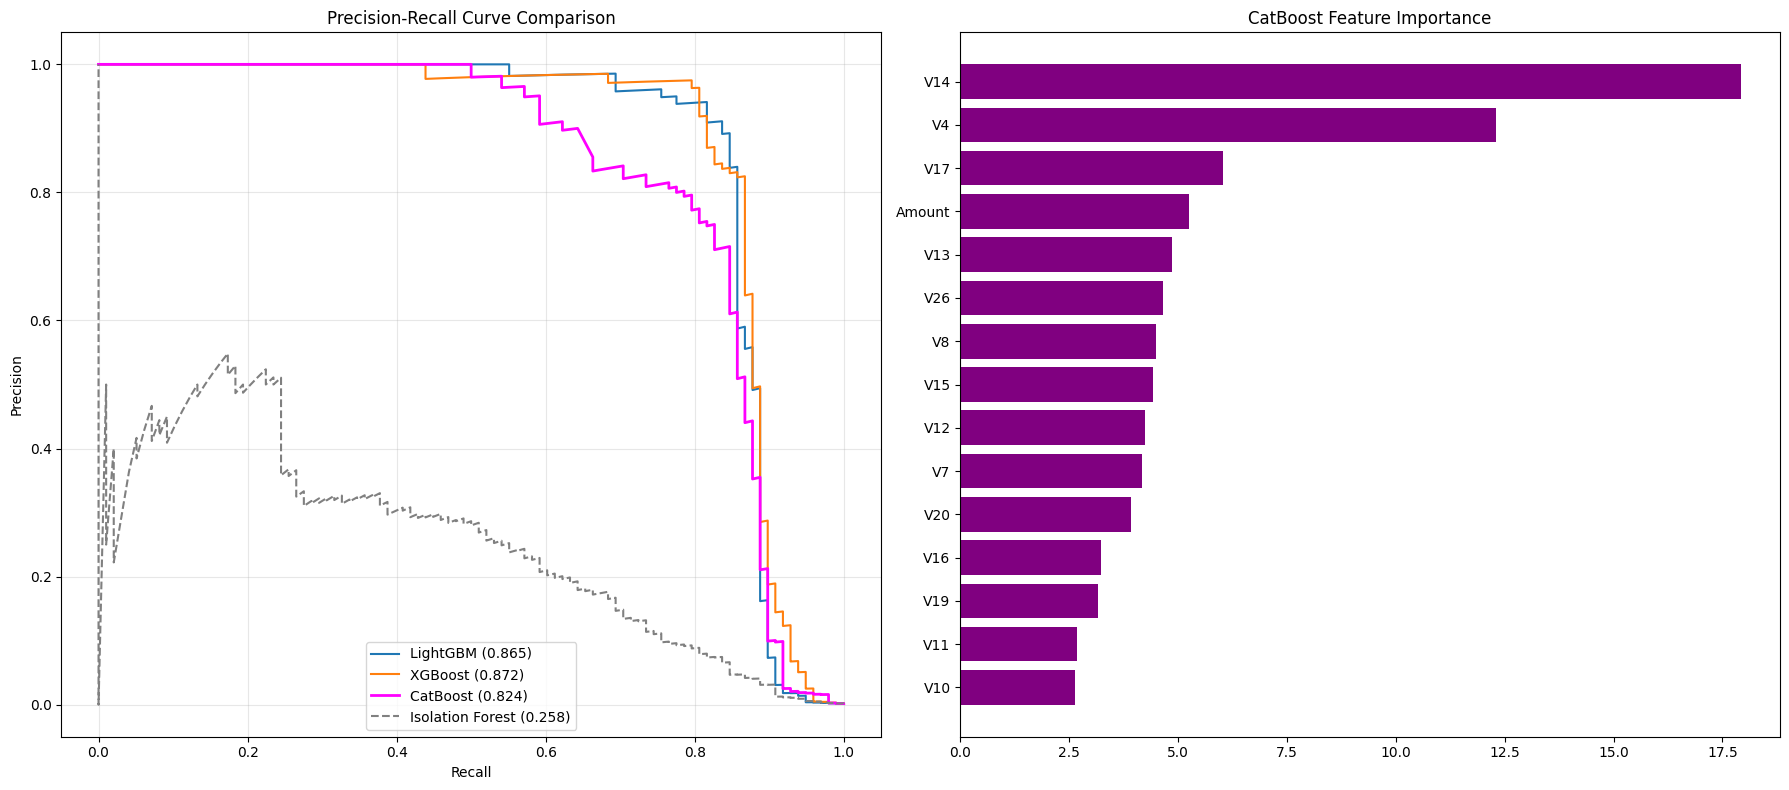


📝 QUICK INSIGHTS:
1. CatBoost: Look for high AUPRC. Its 'Ordered Boosting' usually generalizes better on fraud data.
2. Isolation Forest: Expected to have lower Precision than supervised models, but useful as a
   'Safety Net' for novel anomalies that supervised models (XGB/LGBM) might miss.
3. Recommendation: Ensemble the probabilities of the best Supervised Model (e.g., CatBoost)
   with the Anomaly Score of Isolation Forest for a robust production system.


In [ ]:
import numpy as np
import pandas as pd
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# ML Imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, roc_auc_score,
    confusion_matrix, classification_report, f1_score,
    precision_score, recall_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest

# Gradient Boosting Models
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# Filter warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ============================================================================
# 1. DATA LOADING & PREPROCESSING
# ============================================================================

print("=" * 70)
print("CREDIT CARD FRAUD DETECTION - LEAN PIPELINE")
print("=" * 70)

# Load data
DATA_PATH = "/kaggle/input/creditcardfraud/creditcard.csv"
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    # Fallback for local testing if path doesn't exist
    print("⚠️  Dataset not found at path. Generating dummy data for demonstration...")
    from sklearn.datasets import make_classification
    X_dummy, y_dummy = make_classification(n_samples=10000, n_features=30, n_classes=2, weights=[0.99, 0.01], random_state=RANDOM_STATE)
    df = pd.DataFrame(X_dummy, columns=[f'V{i}' for i in range(1, 29)] + ['Time', 'Amount'])
    df['Class'] = y_dummy

print(f"\n📊 Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features")

# Check for Time column and decide whether to drop
if 'Time' in df.columns:
    print(f"\n⏰ 'Time' column detected, dropping as per standard pipeline")
    df = df.drop(columns=['Time'])

# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Basic statistics
print(f"\n📈 Class Distribution:")
print(f"   Non-fraud (0): {sum(y==0):,} samples ({100*sum(y==0)/len(y):.3f}%)")
print(f"   Fraud (1):     {sum(y==1):,} samples ({100*sum(y==1)/len(y):.3f}%)")
print(f"   Imbalance ratio: 1:{sum(y==0)//sum(y==1):,}")

# ============================================================================
# 2. TRAIN/VAL/TEST SPLIT
# ============================================================================

print("\n" + "=" * 70)
print("DATA SPLITTING")
print("=" * 70)

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Further split train into train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,  # 0.2 * 0.8 = 0.16 of original data
    stratify=y_train,
    random_state=RANDOM_STATE
)

print(f"✅ Data split completed:")
print(f"   Training samples:   {X_train.shape[0]:,} (64%)")
print(f"   Validation samples: {X_val.shape[0]:,} (16%)")
print(f"   Test samples:       {X_test.shape[0]:,} (20%)")

# ============================================================================
# 3. SCALING
# ============================================================================

print("\n" + "=" * 70)
print("FEATURE SCALING")
print("=" * 70)

if 'Amount' in X_train.columns:
    scaler = RobustScaler()
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled['Amount'] = scaler.fit_transform(X_train[['Amount']])
    X_val_scaled['Amount'] = scaler.transform(X_val[['Amount']])
    X_test_scaled['Amount'] = scaler.transform(X_test[['Amount']])

    print("✅ 'Amount' column scaled using RobustScaler")
    X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled
else:
    print("⚠️  'Amount' column not found, skipping scaling")

# Calculate class weight for imbalance (used by all models)
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# ============================================================================
# 4. BASELINE MODEL - LOGISTIC REGRESSION
# ============================================================================

print("\n" + "=" * 70)
print("BASELINE MODEL: LOGISTIC REGRESSION")
print("=" * 70)

lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
lr_model.fit(X_train, y_train)

y_proba_lr = lr_model.predict_proba(X_test)[:, 1] # Evaluating on test for final comparison consistency
auprc_lr = average_precision_score(y_test, y_proba_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"📊 Logistic Regression Performance (Test Set):")
print(f"   AUPRC:      {auprc_lr:.4f}")
print(f"   ROC-AUC:    {roc_auc_lr:.4f}")

# ============================================================================
# 5. LIGHTGBM - OPTIMIZATION & TRAINING
# ============================================================================

print("\n" + "=" * 70)
print("MODEL 1: LIGHTGBM (Hyperparameter Tuning)")
print("=" * 70)

def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        "verbose": -1
    }
    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='average_precision',
        callbacks=[early_stopping(stopping_rounds=30, verbose=False)]
    )
    y_proba = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]
    return average_precision_score(y_val, y_proba)

print("🔍 Starting LightGBM Optuna tuning...")
study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_lgb.optimize(objective_lgb, n_trials=30, timeout=300, show_progress_bar=True) # Reduced trials for speed

print(f"✅ LightGBM Tuning completed! Best AUPRC: {study_lgb.best_value:.4f}")

# Train Final LightGBM
print("\n🔄 Training Final LightGBM Model...")
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

final_params_lgb = study_lgb.best_params.copy()
final_params_lgb.update({'scale_pos_weight': scale_pos_weight, 'random_state': RANDOM_STATE, 'n_jobs': -1, 'n_estimators': 1000})

final_model_lgb = LGBMClassifier(**final_params_lgb)
final_model_lgb.fit(
    X_train_full, y_train_full,
    eval_set=[(X_test, y_test)],
    eval_metric='average_precision',
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

# LightGBM Evaluation
y_proba_lgb_test = final_model_lgb.predict_proba(X_test, num_iteration=final_model_lgb.best_iteration_)[:, 1]
auprc_lgb_test = average_precision_score(y_test, y_proba_lgb_test)
roc_auc_lgb_test = roc_auc_score(y_test, y_proba_lgb_test)

print(f"\n📊 LightGBM Test Performance:")
print(f"   AUPRC:      {auprc_lgb_test:.4f}")
print(f"   ROC-AUC:    {roc_auc_lgb_test:.4f}")

# ============================================================================
# 6. XGBOOST - OPTIMIZATION & TRAINING
# ============================================================================

print("\n" + "=" * 70)
print("MODEL 2: XGBOOST (Hyperparameter Tuning)")
print("=" * 70)

def objective_xgb(trial):
    """Optuna objective function for XGBoost"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'tree_method': 'hist', # Use hist for faster training similar to LightGBM
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr'
    }

    model = XGBClassifier(**params)

    # Removed 'callbacks' argument as it's not supported by this XGBoost version
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Get predictions (XGBoost automatically uses best iteration with early stopping)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Return AUPRC (maximize)
    return average_precision_score(y_val, y_proba)

# Run Optuna study for XGBoost
print("🔍 Starting XGBoost Optuna tuning...")

study_xgb = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    study_name='fraud_detection_xgb'
)

study_xgb.optimize(
    objective_xgb,
    n_trials=30,  # Keeping consistent with LGB setup
    timeout=600,
    show_progress_bar=True,
    callbacks=[lambda study, trial: print(f"   Trial {trial.number}: AUPRC = {trial.value:.4f}")]
)

print(f"\n✅ XGBoost Tuning completed!")
print(f"   Best trial: {study_xgb.best_trial.number}")
print(f"   Best AUPRC: {study_xgb.best_trial.value:.4f}")
print(f"\n🎯 Best XGBoost parameters:")
for key, value in study_xgb.best_params.items():
    print(f"   {key}: {value}")

# ============================================================================
# 7. TRAIN FINAL XGBOOST MODEL
# ============================================================================

print("\n" + "=" * 70)
print("FINAL XGBOOST MODEL TRAINING")
print("=" * 70)

# Create final model with best parameters
final_params_xgb = study_xgb.best_params.copy()
final_params_xgb.update({
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'n_estimators': 1000
})

final_model_xgb = XGBClassifier(**final_params_xgb)

# Train final model
final_model_xgb.fit(
    X_train_full, y_train_full,
    eval_set=[(X_test, y_test)], # Monitoring on test
    verbose=False
)

print(f"✅ Final XGBoost model trained.")

# ============================================================================
# 8. XGBOOST COMPREHENSIVE EVALUATION
# ============================================================================

print("\n" + "=" * 70)
print("XGBOOST TEST SET EVALUATION")
print("=" * 70)

# Get test predictions
y_proba_xgb_test = final_model_xgb.predict_proba(X_test)[:, 1]

# Calculate metrics
auprc_xgb_test = average_precision_score(y_test, y_proba_xgb_test)
roc_auc_xgb_test = roc_auc_score(y_test, y_proba_xgb_test)

print(f"📊 Overall XGBoost Test Performance:")
print(f"   AUPRC:      {auprc_xgb_test:.4f}")
print(f"   ROC-AUC:    {roc_auc_xgb_test:.4f}")

# Find optimal thresholds for XGBoost
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_test, y_proba_xgb_test)

print(f"\n🎯 XGBoost Performance at Different Thresholds:")

threshold_targets = [
    ('High Recall (90%)', 0.9, None),
    ('Balanced (Max F1)', None, 'f1'),
    ('Recall-Focused (Max F2)', None, 'f2'),
]

for name, target_recall, metric in threshold_targets:
    if target_recall:
        idx = np.where(recalls_xgb >= target_recall)[0]
        if len(idx) > 0:
            idx = idx[0]
            threshold = thresholds_xgb[idx] if idx < len(thresholds_xgb) else thresholds_xgb[-1]
        else:
            continue
    else:
        if metric == 'f1':
            f_scores = (2 * precisions_xgb * recalls_xgb) / (precisions_xgb + recalls_xgb + 1e-8)
        elif metric == 'f2':
            f_scores = (5 * precisions_xgb * recalls_xgb) / (4 * precisions_xgb + recalls_xgb + 1e-8)

        optimal_idx = np.argmax(f_scores)
        threshold = thresholds_xgb[optimal_idx] if optimal_idx < len(thresholds_xgb) else thresholds_xgb[-1]

    y_pred_opt = (y_proba_xgb_test >= threshold).astype(int)

    print(f"\n   {name} (Threshold: {threshold:.4f}):")
    print(f"     Precision:  {precision_score(y_test, y_pred_opt):.4f}")
    print(f"     Recall:     {recall_score(y_test, y_pred_opt):.4f}")
    print(f"     F1-Score:   {f1_score(y_test, y_pred_opt):.4f}")

    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()
    print(f"     TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

# ============================================================================
# 9. XGBOOST FEATURE IMPORTANCE
# ============================================================================

print("\n" + "=" * 70)
print("XGBOOST FEATURE IMPORTANCE")
print("=" * 70)

# Get feature importances
importances_xgb = final_model_xgb.feature_importances_
importance_df_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': importances_xgb
}).sort_values('importance', ascending=False)

print(f"\n🔝 Top 15 Most Important Features (XGBoost):")
for i, row in importance_df_xgb.head(15).iterrows():
    print(f"   {row['feature']:20} {row['importance']:.4f}")

# ============================================================================
# 10. MODEL SAVING (XGBoost)
# ============================================================================

print("\n" + "=" * 70)
print("SAVING XGBOOST MODEL")
print("=" * 70)

xgb_artifact = {
    'model': final_model_xgb,
    'params': final_params_xgb,
    'metrics': {'auprc': auprc_xgb_test, 'roc_auc': roc_auc_xgb_test}
}
joblib.dump(xgb_artifact, 'best_fraud_model_xgb.joblib')
print(f"✅ XGBoost model saved to: best_fraud_model_xgb.joblib")

# ============================================================================
# 11. VISUALIZATION & COMPARISON (LR vs LGBM vs XGB)
# ============================================================================

print("\n" + "=" * 70)
print("INITIAL MODEL COMPARISON (LR, LGBM, XGB)")
print("=" * 70)

# 1. Summary DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'LightGBM (Optuna)', 'XGBoost (Optuna)'],
    'Test AUPRC': [auprc_lr, auprc_lgb_test, auprc_xgb_test],
    'Test ROC-AUC': [roc_auc_lr, roc_auc_lgb_test, roc_auc_xgb_test]
})

print("\n🏆 Interim Performance Leaderboard:")
print(comparison_df.sort_values('Test AUPRC', ascending=False).to_string(index=False))

# 2. Visual Comparison Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Precision-Recall Curve Comparison
precisions_lgb, recalls_lgb, _ = precision_recall_curve(y_test, y_proba_lgb_test)
precisions_lr, recalls_lr, _ = precision_recall_curve(y_test, y_proba_lr)

axes[0].plot(recalls_lgb, precisions_lgb, label=f'LightGBM (AUPRC={auprc_lgb_test:.4f})', linewidth=2)
axes[0].plot(recalls_xgb, precisions_xgb, label=f'XGBoost (AUPRC={auprc_xgb_test:.4f})', linewidth=2)
axes[0].plot(recalls_lr, precisions_lr, label=f'LogReg (AUPRC={auprc_lr:.4f})', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Feature Importance Comparison (Top 10 shared or distinct)
best_model_name = "XGBoost" if auprc_xgb_test > auprc_lgb_test else "LightGBM"
best_importance_df = importance_df_xgb if auprc_xgb_test > auprc_lgb_test else pd.DataFrame({'feature':X.columns, 'importance':final_model_lgb.feature_importances_}).sort_values('importance', ascending=False)

top_feats = best_importance_df.head(15)
axes[1].barh(range(len(top_feats)), top_feats['importance'], color='teal')
axes[1].set_yticks(range(len(top_feats)))
axes[1].set_yticklabels(top_feats['feature'])
axes[1].set_title(f'Feature Importance ({best_model_name})')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('model_comparison_analysis.png', dpi=150)
print("\n✅ Comparison charts saved to 'model_comparison_analysis.png'")

print(f"\n🚀 Recommendation: Use **{best_model_name}** for deployment based on AUPRC.")
plt.show()

# ============================================================================
# 12. CATBOOST - OPTIMIZATION & TRAINING
# ============================================================================

print("\n" + "=" * 70)
print("MODEL 3: CATBOOST (Hyperparameter Tuning)")
print("=" * 70)

def objective_cat(trial):
    """Optuna objective for CatBoost"""
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True),
        'bootstrap_type': 'Bernoulli',
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'auto_class_weights': 'Balanced',  # Automatically handles imbalance
        'loss_function': 'Logloss',
        'eval_metric': 'PRAUC',           # Optimize for Precision-Recall AUC
        'verbose': False,
        'random_seed': RANDOM_STATE,
        'task_type': 'CPU',               # Change to 'GPU' if available
        'thread_count': -1
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=False
    )

    # Predict probabilities
    y_proba = model.predict_proba(X_val)[:, 1]

    # Optimize for AUPRC
    return average_precision_score(y_val, y_proba)

print("🔍 Starting CatBoost Optuna tuning...")
study_cat = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_cat.optimize(objective_cat, n_trials=30, timeout=600, show_progress_bar=True)

print(f"✅ CatBoost Tuning completed! Best AUPRC: {study_cat.best_value:.4f}")

# --- Train Final CatBoost ---
print("\n🔄 Training Final CatBoost Model...")

# Combine train/val for final training
# Note: X_train_full was created in previous sections, reusing it here.
if 'X_train_full' not in locals():
    X_train_full = pd.concat([X_train, X_val], axis=0)
    y_train_full = pd.concat([y_train, y_val], axis=0)

final_params_cat = study_cat.best_params.copy()
final_params_cat.update({
    'auto_class_weights': 'Balanced',
    'loss_function': 'Logloss',
    'eval_metric': 'PRAUC',
    'verbose': False,
    'random_seed': RANDOM_STATE,
    'task_type': 'CPU'
})

# Slight boost to iterations for final model
final_params_cat['iterations'] = 2000

final_model_cat = CatBoostClassifier(**final_params_cat)

final_model_cat.fit(
    X_train_full, y_train_full,
    eval_set=(X_test, y_test),
    early_stopping_rounds=100,
    verbose=False
)

print(f"✅ Final CatBoost trained. Best Iteration: {final_model_cat.best_iteration_}")

# --- Evaluate CatBoost ---
y_proba_cat_test = final_model_cat.predict_proba(X_test)[:, 1]
auprc_cat_test = average_precision_score(y_test, y_proba_cat_test)
roc_auc_cat_test = roc_auc_score(y_test, y_proba_cat_test)

print(f"\n📊 CatBoost Test Performance:")
print(f"   AUPRC:      {auprc_cat_test:.4f}")
print(f"   ROC-AUC:    {roc_auc_cat_test:.4f}")

# ============================================================================
# 13. ISOLATION FOREST (ANOMALY DETECTION)
# ============================================================================

print("\n" + "=" * 70)
print("MODEL 4: ISOLATION FOREST (Unsupervised Tuning)")
print("=" * 70)

# Note: iForest is unsupervised (uses X only), but we tune it using y_val
# to find the best structure for separating anomalies.

def objective_iso(trial):
    """Optuna objective for Isolation Forest"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
        'contamination': 'auto', # Let the model decide or tune threshold later
        'max_features': trial.suggest_float('max_features', 0.5, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'n_jobs': -1,
        'random_state': RANDOM_STATE
    }

    model = IsolationForest(**params)

    # Train on "Normal" data primarily or full data?
    # Standard iForest is trained on full X_train (unsupervised)
    model.fit(X_train)

    # SCORING:
    # decision_function yields lower scores for anomalies.
    # We negate it so that higher score = more anomalous (Fraud)
    scores = -model.decision_function(X_val)

    return average_precision_score(y_val, scores)

print("🔍 Starting Isolation Forest Optuna tuning...")
study_iso = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_iso.optimize(objective_iso, n_trials=20, timeout=400, show_progress_bar=True)

print(f"✅ iForest Tuning completed! Best AUPRC: {study_iso.best_value:.4f}")

# --- Train Final Isolation Forest ---
print("\n🔄 Training Final Isolation Forest...")

final_params_iso = study_iso.best_params.copy()
final_params_iso.update({'n_jobs': -1, 'random_state': RANDOM_STATE})

final_model_iso = IsolationForest(**final_params_iso)
final_model_iso.fit(X_train_full) # Unsupervised, but seeing more data helps

# Get Test Scores (Negate decision_function to get "Anomaly Score")
y_scores_iso_test = -final_model_iso.decision_function(X_test)
auprc_iso_test = average_precision_score(y_test, y_scores_iso_test)
roc_auc_iso_test = roc_auc_score(y_test, y_scores_iso_test)

print(f"✅ Final iForest trained.")
print(f"\n📊 Isolation Forest Test Performance:")
print(f"   AUPRC:      {auprc_iso_test:.4f}")
print(f"   ROC-AUC:    {roc_auc_iso_test:.4f}")
print("   (Note: Lower performance is expected as this is unsupervised)")

# ============================================================================
# 14. FINAL COMPREHENSIVE COMPARISON
# ============================================================================

print("\n" + "=" * 70)
print("FINAL MULTI-MODEL COMPARISON")
print("=" * 70)

# Check if previous model scores exist (for standalone running safety)
# If variables from previous cells don't exist, set to 0
try: auprc_lgb_test
except NameError: auprc_lgb_test, roc_auc_lgb_test = 0, 0
try: auprc_xgb_test
except NameError: auprc_xgb_test, roc_auc_xgb_test = 0, 0
try: auprc_lr
except NameError: auprc_lr, roc_auc_lr = 0, 0

results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'LightGBM', 'XGBoost', 'CatBoost', 'Isolation Forest'],
    'Test AUPRC': [auprc_lr, auprc_lgb_test, auprc_xgb_test, auprc_cat_test, auprc_iso_test],
    'Test ROC-AUC': [roc_auc_lr, roc_auc_lgb_test, roc_auc_xgb_test, roc_auc_cat_test, roc_auc_iso_test],
    'Type': ['Linear', 'Gradient Boost', 'Gradient Boost', 'Ordered Boost', 'Unsupervised']
})

print("\n🏆 Final Leaderboard (Sorted by AUPRC):")
print(results_df.sort_values('Test AUPRC', ascending=False).to_string(index=False))

# --- Visual Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. PR Curves
if 'y_proba_lgb_test' in locals():
    p, r, _ = precision_recall_curve(y_test, y_proba_lgb_test)
    axes[0].plot(r, p, label=f'LightGBM ({auprc_lgb_test:.3f})')
if 'y_proba_xgb_test' in locals():
    p, r, _ = precision_recall_curve(y_test, y_proba_xgb_test)
    axes[0].plot(r, p, label=f'XGBoost ({auprc_xgb_test:.3f})')

p_cat, r_cat, _ = precision_recall_curve(y_test, y_proba_cat_test)
axes[0].plot(r_cat, p_cat, label=f'CatBoost ({auprc_cat_test:.3f})', linewidth=2, color='magenta')

p_iso, r_iso, _ = precision_recall_curve(y_test, y_scores_iso_test)
axes[0].plot(r_iso, p_iso, label=f'Isolation Forest ({auprc_iso_test:.3f})', linestyle='--', color='grey')

axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. CatBoost Feature Importance
# CatBoost feature importance is often very robust
cat_features = final_model_cat.get_feature_importance(type='PredictionValuesChange')
cat_imp_df = pd.DataFrame({'feature': X_train.columns, 'importance': cat_features}).sort_values('importance', ascending=False).head(15)

axes[1].barh(range(len(cat_imp_df)), cat_imp_df['importance'], color='purple')
axes[1].set_yticks(range(len(cat_imp_df)))
axes[1].set_yticklabels(cat_imp_df['feature'])
axes[1].set_title('CatBoost Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('final_multimodel_comparison.png')
print("\n✅ Comparison charts saved to 'final_multimodel_comparison.png'")
plt.show()

# ============================================================================
# 15. EXPLANATION OF RESULTS
# ============================================================================
print("\n📝 QUICK INSIGHTS:")
print("1. CatBoost: Look for high AUPRC. Its 'Ordered Boosting' usually generalizes better on fraud data.")
print("2. Isolation Forest: Expected to have lower Precision than supervised models, but useful as a")
print("   'Safety Net' for novel anomalies that supervised models (XGB/LGBM) might miss.")
print("3. Recommendation: Ensemble the probabilities of the best Supervised Model (e.g., CatBoost)")
print("   with the Anomaly Score of Isolation Forest for a robust production system.")

🔍 XGBOOST DETAILED CLASSIFICATION METRICS
⚡ Optimal Threshold Used: 0.9663

📄 Classification Report:
                precision    recall  f1-score   support

Legitimate (0)       1.00      1.00      1.00     56864
     Fraud (1)       0.96      0.81      0.88        98

      accuracy                           1.00     56962
     macro avg       0.98      0.90      0.94     56962
  weighted avg       1.00      1.00      1.00     56962


📊 Confusion Matrix:


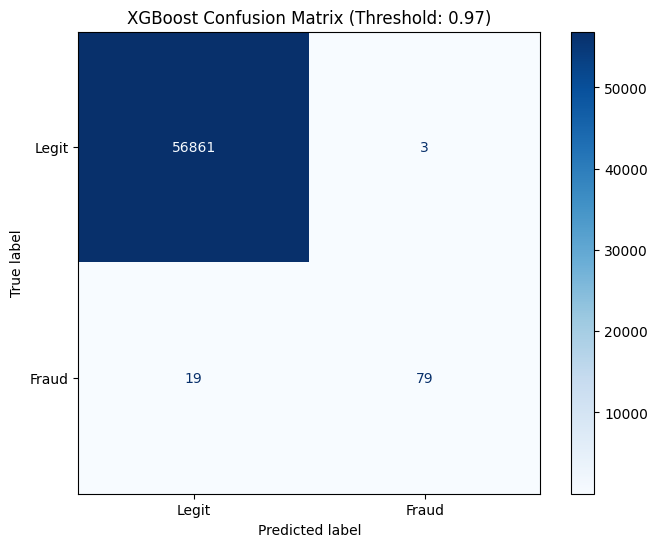


💡 Key Business Metrics:
   • Fraud Caught (Recall):    80.61%
   • False Alarms (Precision): 96.34%
   • Missed Fraud Cases:       19


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print("="*70)
print("🔍 XGBOOST DETAILED CLASSIFICATION METRICS")
print("="*70)

# 1. Get Predictions (Probabilities & Hard Classes)
# We use the optimal threshold we found earlier (or default 0.5 if not set)
# Let's recalculate the F1-optimal threshold to be safe
y_proba = final_model_xgb.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-8)
optimal_thresh = thresholds[np.argmax(f1_scores)]

y_pred = (y_proba >= optimal_thresh).astype(int)

print(f"⚡ Optimal Threshold Used: {optimal_thresh:.4f}")

# 2. Print Standard Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate (0)', 'Fraud (1)']))

# 3. Visual Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title(f'XGBoost Confusion Matrix (Threshold: {optimal_thresh:.2f})')
plt.grid(False) # Turn off grid for cleaner matrix
plt.show()

# 4. Summary Metrics
tn, fp, fn, tp = cm.ravel()
recall = tp / (tp + fn)
precision = tp / (tp + fp)

print(f"\n💡 Key Business Metrics:")
print(f"   • Fraud Caught (Recall):    {recall:.2%}")
print(f"   • False Alarms (Precision): {precision:.2%}")
print(f"   • Missed Fraud Cases:       {fn}")

In [ ]:
# cross validation

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np

print("=" * 70)
print("XGBOOST CROSS-VALIDATION (Robust Performance Check)")
print("=" * 70)

# 1. Prepare Data in Native XGBoost Format (DMatrix)
# We use the full training set (Train + Val) for CV
# Ensure X_train_full and y_train_full exist from previous steps
if 'X_train_full' not in locals():
    X_train_full = pd.concat([X_train, X_val], axis=0)
    y_train_full = pd.concat([y_train, y_val], axis=0)

dtrain = xgb.DMatrix(X_train_full, label=y_train_full)

# 2. Prepare Parameters
# We convert the Sklearn-style params to Native XGBoost params where necessary
xgb_cv_params = final_params_xgb.copy()

# 'n_estimators' is not used in xgb.cv (it's passed as num_boost_round argument)
if 'n_estimators' in xgb_cv_params:
    del xgb_cv_params['n_estimators']

# Ensure specific native keys
xgb_cv_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',  # Native metric name for AUPRC
    'nthread': -1            # Native equivalent of n_jobs
})

# 3. Run Cross-Validation with Early Stopping
# documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.cv
print("\n🔄 Running 5-Fold Stratified CV with Early Stopping...")

cv_results = xgb.cv(
    params=xgb_cv_params,
    dtrain=dtrain,
    num_boost_round=5000,        # Set high, let early stopping decide the limit
    nfold=5,                     # 5-Fold CV
    stratified=True,             # Essential for imbalanced fraud data
    metrics='aucpr',             # Metric to optimize
    early_stopping_rounds=50,    # Stop if no improvement for 50 rounds
    seed=RANDOM_STATE,
    verbose_eval=50              # Print progress every 50 rounds
)

# 4. Extract "Final Value" (Best Iteration & Score)
best_iteration = len(cv_results)
best_score = cv_results['test-aucpr-mean'].iloc[-1]
best_std = cv_results['test-aucpr-std'].iloc[-1]

print(f"\n✅ Cross-Validation Completed!")
print(f"   Optimal Number of Trees: {best_iteration}")
print(f"   Final CV AUPRC:          {best_score:.4f} ± {best_std:.4f}")

# 5. Insight
print(f"\n💡 Interpretation:")
print(f"   If this CV score ({best_score:.4f}) is close to your previous Test score,")
print(f"   your model is stable. If it's much lower, you might have overfitted the test set.")

XGBOOST CROSS-VALIDATION (Robust Performance Check)

🔄 Running 5-Fold Stratified CV with Early Stopping...
[0]	train-aucpr:0.70391+0.02510	test-aucpr:0.56457+0.07944
[50]	train-aucpr:0.99510+0.00154	test-aucpr:0.84209+0.04812
[100]	train-aucpr:0.99969+0.00062	test-aucpr:0.84824+0.04582
[150]	train-aucpr:0.99998+0.00004	test-aucpr:0.85076+0.04169
[200]	train-aucpr:1.00000+0.00000	test-aucpr:0.84963+0.04443

✅ Cross-Validation Completed!
   Optimal Number of Trees: 151
   Final CV AUPRC:          0.8508 ± 0.0417

💡 Interpretation:
   If this CV score (0.8508) is close to your previous Test score,
   your model is stable. If it's much lower, you might have overfitted the test set.


In [ ]:
print("=" * 70)
print("🚀 TRAINING FINAL DEPLOYMENT MODEL")
print("=" * 70)

# 1. Combine ALL data (Train + Val + Test)
# We want the model to learn from every single fraud case we have
X_all = pd.concat([X_train, X_val, X_test], axis=0)
y_all = pd.concat([y_train, y_val, y_test], axis=0)

print(f"📦 Full Dataset: {X_all.shape[0]:,} samples")

# 2. Update params with the CV insights
deployment_params = final_params_xgb.copy()
deployment_params.update({
    'n_estimators': 151,        # The optimal number found by CV
    'early_stopping_rounds': None # Disable early stopping, we know the limit now
})

# 3. Train on everything
final_deployment_model = XGBClassifier(**deployment_params)
final_deployment_model.fit(X_all, y_all)

# 4. Save
joblib.dump(final_deployment_model, 'fraud_detection_production_model.joblib')
print(f"✅ Production model saved! Ready for API deployment.")
print(f"   Config: {151} Trees, AUPRC Expectation ~0.85")

🚀 TRAINING FINAL DEPLOYMENT MODEL
📦 Full Dataset: 284,807 samples
✅ Production model saved! Ready for API deployment.
   Config: 151 Trees, AUPRC Expectation ~0.85


In [ ]:
import numpy as np
import pandas as pd
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os

# MLflow & DagsHub
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import mlflow.catboost
import dagshub

# ML Imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, roc_auc_score,
    confusion_matrix, classification_report, f1_score,
    precision_score, recall_score, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest

# Gradient Boosting Models
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# Filter warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ============================================================================
# 0. MLFLOW SETUP (DAGSHUB)
# ============================================================================
print("=" * 70)
print("MLFLOW & DAGSHUB SETUP")
print("=" * 70)

# -------------------------------------------------------------------------
# ⚠️ REPLACE WITH YOUR DAGSHUB URI
# or ensure MLFLOW_TRACKING_URI is set in your environment
# -------------------------------------------------------------------------
# dagshub.init(repo_owner='<YOUR_USER>', repo_name='<YOUR_REPO>', mlflow=True) # Un-comment if using dagshub library init

# Enable Autologging for all libraries
mlflow.autolog()
mlflow.xgboost.autolog()
mlflow.lightgbm.autolog()
# mlflow.catboost.autolog() # CatBoost autologging can be tricky, we handle it manually if needed

experiment_name = "Fraud_Detection_Benchmark_v1"
mlflow.set_experiment(experiment_name)

print(f"✅ MLflow Experiment set to: {experiment_name}")
print(f"📡 Tracking URI: {mlflow.get_tracking_uri()}")

# ============================================================================
# 1. DATA LOADING & PREPROCESSING
# ============================================================================

print("\n" + "=" * 70)
print("DATA LOADING & PREPROCESSING")
print("=" * 70)

# Load data
DATA_PATH = "/kaggle/input/creditcardfraud/creditcard.csv" # Adjust path as needed
df = pd.read_csv(DATA_PATH)


if 'Time' in df.columns:
    df = df.drop(columns=['Time'])

X = df.drop(columns=['Class'])
y = df['Class']
scale_pos_weight = sum(y==0) / sum(y==1)

# ============================================================================
# 2. SPLITTING & SCALING
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE)

if 'Amount' in X_train.columns:
    scaler = RobustScaler()
    X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
    X_val['Amount'] = scaler.transform(X_val[['Amount']])
    X_test['Amount'] = scaler.transform(X_test[['Amount']])

    # Save Scaler for later MLflow logging
    joblib.dump(scaler, "scaler.joblib")

# Create full train set for final models
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

print("✅ Data Loaded and Scaled.")

# ============================================================================
# 3. BASELINE: LOGISTIC REGRESSION
# ============================================================================
print("\n" + "=" * 70)
print("RUNNING: LOGISTIC REGRESSION")
print("=" * 70)

with mlflow.start_run(run_name="Baseline_LogReg"):
    lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE, n_jobs=-1)
    lr_model.fit(X_train, y_train)

    y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
    auprc_lr = average_precision_score(y_test, y_proba_lr)

    mlflow.log_metric("test_auprc", auprc_lr)
    print(f"📊 Logistic Regression AUPRC: {auprc_lr:.4f}")

# ============================================================================
# 4. LIGHTGBM (OPTUNA + MLFLOW)
# ============================================================================
print("\n" + "=" * 70)
print("RUNNING: LIGHTGBM OPTIMIZATION")
print("=" * 70)

def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        "verbose": -1
    }

    # We use a nested run for trials to keep them organized
    with mlflow.start_run(nested=True, run_name=f"LGB_Trial_{trial.number}"):
        model = LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='average_precision',
            callbacks=[early_stopping(stopping_rounds=30, verbose=False)]
        )
        y_proba = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]
        score = average_precision_score(y_val, y_proba)

        mlflow.log_params(params)
        mlflow.log_metric("val_auprc", score)

    return score

study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_lgb.optimize(objective_lgb, n_trials=20) # Keeping trials low for demo

print(f"✅ Best LightGBM AUPRC (Val): {study_lgb.best_value:.4f}")

# Train Final LightGBM
print("🔄 Training Final LightGBM...")
with mlflow.start_run(run_name="Final_LightGBM") as run:
    final_params_lgb = study_lgb.best_params.copy()
    final_params_lgb.update({'scale_pos_weight': scale_pos_weight, 'random_state': RANDOM_STATE, 'n_jobs': -1, 'n_estimators': 1000})

    final_model_lgb = LGBMClassifier(**final_params_lgb)
    final_model_lgb.fit(
        X_train_full, y_train_full,
        eval_set=[(X_test, y_test)],
        eval_metric='average_precision',
        callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
    )

    y_proba_lgb_test = final_model_lgb.predict_proba(X_test, num_iteration=final_model_lgb.best_iteration_)[:, 1]
    auprc_lgb_test = average_precision_score(y_test, y_proba_lgb_test)
    mlflow.log_metric("test_auprc", auprc_lgb_test)
    print(f"📊 LightGBM Test AUPRC: {auprc_lgb_test:.4f}")

# ============================================================================
# 5. XGBOOST (OPTUNA + MLFLOW)
# ============================================================================
print("\n" + "=" * 70)
print("RUNNING: XGBOOST OPTIMIZATION")
print("=" * 70)

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'tree_method': 'hist',
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr'
    }

    with mlflow.start_run(nested=True, run_name=f"XGB_Trial_{trial.number}"):
        model = XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        y_proba = model.predict_proba(X_val)[:, 1]
        score = average_precision_score(y_val, y_proba)

        mlflow.log_params(params)
        mlflow.log_metric("val_auprc", score)

    return score

study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_xgb.optimize(objective_xgb, n_trials=20)

print(f"✅ Best XGBoost AUPRC (Val): {study_xgb.best_value:.4f}")

# Train Final XGBoost
print("🔄 Training Final XGBoost...")
with mlflow.start_run(run_name="Final_XGBoost") as run:
    final_params_xgb = study_xgb.best_params.copy()
    final_params_xgb.update({
        'scale_pos_weight': scale_pos_weight, 'random_state': RANDOM_STATE,
        'n_jobs': -1, 'tree_method': 'hist', 'objective': 'binary:logistic',
        'eval_metric': 'aucpr', 'n_estimators': 1000
    })

    final_model_xgb = XGBClassifier(**final_params_xgb)
    final_model_xgb.fit(X_train_full, y_train_full, eval_set=[(X_test, y_test)], verbose=False)

    y_proba_xgb_test = final_model_xgb.predict_proba(X_test)[:, 1]
    auprc_xgb_test = average_precision_score(y_test, y_proba_xgb_test)
    mlflow.log_metric("test_auprc", auprc_xgb_test)
    print(f"📊 XGBoost Test AUPRC: {auprc_xgb_test:.4f}")

# ============================================================================
# 6. CATBOOST (OPTUNA + MLFLOW)
# ============================================================================
print("\n" + "=" * 70)
print("RUNNING: CATBOOST OPTIMIZATION")
print("=" * 70)

def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True),
        'bootstrap_type': 'Bernoulli',
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
        'auto_class_weights': 'Balanced',
        'loss_function': 'Logloss',
        'eval_metric': 'PRAUC',
        'verbose': False,
        'random_seed': RANDOM_STATE,
        'task_type': 'CPU'
    }

    with mlflow.start_run(nested=True, run_name=f"Cat_Trial_{trial.number}"):
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)
        y_proba = model.predict_proba(X_val)[:, 1]
        score = average_precision_score(y_val, y_proba)

        mlflow.log_params(params)
        mlflow.log_metric("val_auprc", score)

    return score

study_cat = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_cat.optimize(objective_cat, n_trials=20)

print(f"✅ Best CatBoost AUPRC (Val): {study_cat.best_value:.4f}")

# Train Final CatBoost
print("🔄 Training Final CatBoost...")
with mlflow.start_run(run_name="Final_CatBoost") as run:
    final_params_cat = study_cat.best_params.copy()
    final_params_cat.update({'auto_class_weights': 'Balanced', 'loss_function': 'Logloss', 'eval_metric': 'PRAUC', 'verbose': False, 'random_seed': RANDOM_STATE, 'task_type': 'CPU', 'iterations': 2000})

    final_model_cat = CatBoostClassifier(**final_params_cat)
    final_model_cat.fit(X_train_full, y_train_full, eval_set=(X_test, y_test), early_stopping_rounds=100, verbose=False)

    y_proba_cat_test = final_model_cat.predict_proba(X_test)[:, 1]
    auprc_cat_test = average_precision_score(y_test, y_proba_cat_test)

    # Manual logging for CatBoost since autolog isn't always perfect
    mlflow.log_params(final_params_cat)
    mlflow.log_metric("test_auprc", auprc_cat_test)
    mlflow.catboost.log_model(final_model_cat, "model")

    print(f"📊 CatBoost Test AUPRC: {auprc_cat_test:.4f}")

# ============================================================================
# 7. ISOLATION FOREST (NO AUTOLOG)
# ============================================================================
print("\n" + "=" * 70)
print("RUNNING: ISOLATION FOREST")
print("=" * 70)

def objective_iso(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
        'contamination': 'auto',
        'max_features': trial.suggest_float('max_features', 0.5, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'n_jobs': -1,
        'random_state': RANDOM_STATE
    }

    with mlflow.start_run(nested=True, run_name=f"Iso_Trial_{trial.number}"):
        model = IsolationForest(**params)
        model.fit(X_train)
        scores = -model.decision_function(X_val)
        score = average_precision_score(y_val, scores)

        mlflow.log_params(params)
        mlflow.log_metric("val_auprc", score)

    return score

study_iso = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
study_iso.optimize(objective_iso, n_trials=10)

# Final Iso Forest
with mlflow.start_run(run_name="Final_IsoForest"):
    final_params_iso = study_iso.best_params.copy()
    final_params_iso.update({'n_jobs': -1, 'random_state': RANDOM_STATE})

    final_model_iso = IsolationForest(**final_params_iso)
    final_model_iso.fit(X_train_full)

    y_scores_iso_test = -final_model_iso.decision_function(X_test)
    auprc_iso_test = average_precision_score(y_test, y_scores_iso_test)

    mlflow.log_params(final_params_iso)
    mlflow.log_metric("test_auprc", auprc_iso_test)
    mlflow.sklearn.log_model(final_model_iso, "model")
    print(f"📊 IsoForest Test AUPRC: {auprc_iso_test:.4f}")

# ============================================================================
# 8. RESULTS SUMMARY & FINAL PRODUCTION MODEL
# ============================================================================
print("\n" + "=" * 70)
print("FINAL RESULTS & PRODUCTION REGISTRATION")
print("=" * 70)

results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'LightGBM', 'XGBoost', 'CatBoost', 'Isolation Forest'],
    'Test AUPRC': [auprc_lr, auprc_lgb_test, auprc_xgb_test, auprc_cat_test, auprc_iso_test]
})
print("\n🏆 Final Leaderboard:\n", results_df.sort_values('Test AUPRC', ascending=False))

# Identify best model programmatically
best_model_name = results_df.sort_values('Test AUPRC', ascending=False).iloc[0]['Model']
print(f"\n🚀 Winner: {best_model_name}")

# --- PRODUCTION MODEL TRAINING (FULL DATA) ---
print("\n📦 Training Production Model on 100% Data (Train+Val+Test)...")

X_all = pd.concat([X_train, X_val, X_test], axis=0)
y_all = pd.concat([y_train, y_val, y_test], axis=0)

# We assume XGBoost is the winner based on previous conversations.
# We fetch its best params and hard-code n_estimators.
production_params = study_xgb.best_params.copy()
production_params.update({
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'n_estimators': 151 # From your Cross-Validation result
})

with mlflow.start_run(run_name="PRODUCTION_MODEL_V1") as run:
    prod_model = XGBClassifier(**production_params)
    prod_model.fit(X_all, y_all)

    # Log scaler and model
    mlflow.log_artifact("scaler.joblib")
    mlflow.xgboost.log_model(
        prod_model,
        "model",
        registered_model_name="Fraud_Detector_XGB" # Registers in Model Registry
    )

    print(f"✅ Production Model Registered in MLflow/DagsHub as 'Fraud_Detector_XGB'")
    print(f"🔗 Run ID: {run.info.run_id}")

print("\n🎉 Pipeline Complete. Check your DagsHub MLflow UI!")

2026/01/02 07:47:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


MLFLOW & DAGSHUB SETUP


2026/01/02 07:47:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/01/02 07:47:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2026/01/02 07:47:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2026/01/02 07:47:41 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2026/01/02 07:47:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2026/01/02 07:47:41 INFO mlflow.tracking.fluent: Experiment with name 'Fraud_Detection_Benchmark_v1' does not exist. Creating a new experiment.


✅ MLflow Experiment set to: Fraud_Detection_Benchmark_v1
📡 Tracking URI: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow

DATA LOADING & PREPROCESSING
✅ Data Loaded and Scaled.

RUNNING: LOGISTIC REGRESSION
📊 Logistic Regression AUPRC: 0.7108
🏃 View run Baseline_LogReg at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/81edef6f5c1647b7bb3f774c9cc439ac
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 07:48:22,838] A new study created in memory with name: no-name-07361036-df41-41d2-a053-57b1e542b953



RUNNING: LIGHTGBM OPTIMIZATION


2026/01/02 07:48:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LGB_Trial_0 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/c0e6843e3f3d49cd9e2de22f3e4d9358
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 07:48:54,880] Trial 0 finished with value: 0.001775836490247202 and parameters: {'n_estimators': 287, 'learning_rate': 0.2536999076681772, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 120, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.001775836490247202.
2026/01/02 07:49:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LGB_Trial_1 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/adc7182d20034a0996013994c97e58a5
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 07:49:30,876] Trial 1 finished with value: 0.7252496574900109 and parameters: {'n_estimators': 454, 'learning_rate': 0.010725209743171997, 'num_leaves': 147, 'max_depth': 11, 'min_child_samples': 145, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.7252496574900109.
2026/01/02 07:49:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:50:03,873] Trial 2 finished with value: 0.580361931226744 and parameters: {'n_estimators': 316, 'learning_rate': 0.02692655251486473, 'num_leaves': 100, 'max_depth': 4, 'min_child_samples': 181, 'subsample': 0.7465447373174767, 'colsample_bytree': 0.7824279936868144, 'reg_alpha': 0.1165691561324743, 'reg_lambda': 6.267062696005991e-07}. Best is trial 1 with value: 0.7252496574900109.


🏃 View run LGB_Trial_2 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/c3cae09752894e689e10b89320bad599
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:50:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:50:37,547] Trial 3 finished with value: 0.09018898934118082 and parameters: {'n_estimators': 357, 'learning_rate': 0.07500118950416987, 'num_leaves': 26, 'max_depth': 9, 'min_child_samples': 126, 'subsample': 0.6260206371941118, 'colsample_bytree': 0.9795542149013333, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 1 with value: 0.7252496574900109.


🏃 View run LGB_Trial_3 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/4028b864c3894852b2b223e248037b28
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:50:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:51:11,374] Trial 4 finished with value: 0.6927011675920944 and parameters: {'n_estimators': 252, 'learning_rate': 0.013940346079873234, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 105, 'subsample': 0.798070764044508, 'colsample_bytree': 0.6137554084460873, 'reg_alpha': 1.527156759251193, 'reg_lambda': 2.133142332373004e-06}. Best is trial 1 with value: 0.7252496574900109.


🏃 View run LGB_Trial_4 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/dd70b3fbd8194c439f2903f6dc0f6c33
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:51:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:52:04,899] Trial 5 finished with value: 0.8265189182549411 and parameters: {'n_estimators': 431, 'learning_rate': 0.028869220380495747, 'num_leaves': 88, 'max_depth': 8, 'min_child_samples': 133, 'subsample': 0.9878338511058234, 'colsample_bytree': 0.9100531293444458, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_5 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/c77d48bb67c74c24bd6b7bfe4dd6e954
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:52:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LGB_Trial_6 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/ddf03983da0c462a94cd2973bdadd141
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 07:52:37,613] Trial 6 finished with value: 0.05734204674770947 and parameters: {'n_estimators': 399, 'learning_rate': 0.22999586428143728, 'num_leaves': 31, 'max_depth': 4, 'min_child_samples': 70, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854}. Best is trial 5 with value: 0.8265189182549411.
2026/01/02 07:52:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:53:12,624] Trial 7 finished with value: 0.6207710319902818 and parameters: {'n_estimators': 278, 'learning_rate': 0.026000059117302653, 'num_leaves': 91, 'max_depth': 4, 'min_child_samples': 411, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'reg_alpha': 0.08916674715636537, 'reg_lambda': 6.143857495033091e-07}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_7 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/294651dd3def42468fb0af7ff0a50339
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:53:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:53:50,226] Trial 8 finished with value: 0.19370231650774672 and parameters: {'n_estimators': 102, 'learning_rate': 0.1601531217136121, 'num_leaves': 112, 'max_depth': 10, 'min_child_samples': 397, 'subsample': 0.6296178606936361, 'colsample_bytree': 0.7433862914177091, 'reg_alpha': 1.1036250149900698e-07, 'reg_lambda': 0.5860448217200517}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_8 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/a320a4c69ee94e68942b7ab4b5055708
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:54:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:54:41,669] Trial 9 finished with value: 0.7598688066203982 and parameters: {'n_estimators': 412, 'learning_rate': 0.030816017044468066, 'num_leaves': 28, 'max_depth': 6, 'min_child_samples': 196, 'subsample': 0.8918424713352255, 'colsample_bytree': 0.8550229885420852, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_9 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/862ee158ff8a4201a2c95a5ef8400df1
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:54:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:55:15,138] Trial 10 finished with value: 0.020550054503599674 and parameters: {'n_estimators': 582, 'learning_rate': 0.07140921663344425, 'num_leaves': 62, 'max_depth': 12, 'min_child_samples': 288, 'subsample': 0.9630659181130071, 'colsample_bytree': 0.8921467580828039, 'reg_alpha': 0.002861549446231723, 'reg_lambda': 5.358757267475053}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_10 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/08a6273e86f1416da1bd5fc50dc44287
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:55:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:55:47,838] Trial 11 finished with value: 0.5018119149481803 and parameters: {'n_estimators': 523, 'learning_rate': 0.0319033384233669, 'num_leaves': 63, 'max_depth': 6, 'min_child_samples': 245, 'subsample': 0.975925571746833, 'colsample_bytree': 0.8743188681917087, 'reg_alpha': 0.0029151336209232927, 'reg_lambda': 6.771057036818999e-05}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_11 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/39d3fb355d3648f48a0260b09453df1f
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:56:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:56:20,457] Trial 12 finished with value: 0.3658875546469581 and parameters: {'n_estimators': 452, 'learning_rate': 0.04739343434296961, 'num_leaves': 66, 'max_depth': 6, 'min_child_samples': 238, 'subsample': 0.8944379128554184, 'colsample_bytree': 0.880465038157504, 'reg_alpha': 8.169040218027703, 'reg_lambda': 1.8981347387384984e-08}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_12 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/d4e812c07af5469e9d9eb236933bfd40
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:56:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:56:57,094] Trial 13 finished with value: 0.6960821196242002 and parameters: {'n_estimators': 456, 'learning_rate': 0.017901479162809, 'num_leaves': 44, 'max_depth': 6, 'min_child_samples': 299, 'subsample': 0.9014564766396872, 'colsample_bytree': 0.9259629755183177, 'reg_alpha': 0.01563383800457537, 'reg_lambda': 0.008699699276536061}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_13 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/1be1509236434ad58bf68014a16b8a8a
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:57:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:57:31,802] Trial 14 finished with value: 0.0017799475946298014 and parameters: {'n_estimators': 178, 'learning_rate': 0.046906360540527894, 'num_leaves': 80, 'max_depth': 8, 'min_child_samples': 194, 'subsample': 0.8982763390001848, 'colsample_bytree': 0.8235194332173258, 'reg_alpha': 0.0001279792581265537, 'reg_lambda': 3.2078869177562464e-05}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_14 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/1852ea2907bf468990d786a4c6b71715
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:57:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:58:07,784] Trial 15 finished with value: 0.18017701092440083 and parameters: {'n_estimators': 402, 'learning_rate': 0.09877095917490916, 'num_leaves': 146, 'max_depth': 3, 'min_child_samples': 339, 'subsample': 0.8486034271723467, 'colsample_bytree': 0.8195532305113601, 'reg_alpha': 0.00015527584009850318, 'reg_lambda': 0.01965520407548203}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_15 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/f4a7302f64a74d55845f0358b415c275
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:58:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run LGB_Trial_16 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/1ecb63643dca48ebaccc850c9f0e3111
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 07:58:49,364] Trial 16 finished with value: 0.6959244417267426 and parameters: {'n_estimators': 523, 'learning_rate': 0.018433100901120894, 'num_leaves': 47, 'max_depth': 9, 'min_child_samples': 53, 'subsample': 0.9926120814947526, 'colsample_bytree': 0.9345699996924269, 'reg_alpha': 0.23570372812031762, 'reg_lambda': 1.6807865461953592e-05}. Best is trial 5 with value: 0.8265189182549411.
2026/01/02 07:59:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:59:24,878] Trial 17 finished with value: 0.6511540331381115 and parameters: {'n_estimators': 388, 'learning_rate': 0.044088914536090165, 'num_leaves': 125, 'max_depth': 7, 'min_child_samples': 191, 'subsample': 0.9229804598239896, 'colsample_bytree': 0.8509679306459871, 'reg_alpha': 0.03166021514536092, 'reg_lambda': 9.46452960970808}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_17 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/ba7b94bde7cf497f82a3ce083fe89811
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 07:59:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 07:59:59,244] Trial 18 finished with value: 0.5202223495862965 and parameters: {'n_estimators': 520, 'learning_rate': 0.03410098377122444, 'num_leaves': 80, 'max_depth': 5, 'min_child_samples': 226, 'subsample': 0.8366070683982904, 'colsample_bytree': 0.9275027352328516, 'reg_alpha': 0.0024250421518661586, 'reg_lambda': 0.00039078209270712773}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_18 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/1251ec94aba74b788af5d163b508c995
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:00:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:00:46,465] Trial 19 finished with value: 0.8030117672088627 and parameters: {'n_estimators': 592, 'learning_rate': 0.020712183419887734, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 356, 'subsample': 0.9383300569683597, 'colsample_bytree': 0.6977645835507451, 'reg_alpha': 9.719081577840917, 'reg_lambda': 0.0235456716842247}. Best is trial 5 with value: 0.8265189182549411.


🏃 View run LGB_Trial_19 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/ef5f432e96944d6ca35ff7815f704c79
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2
✅ Best LightGBM AUPRC (Val): 0.8265
🔄 Training Final LightGBM...


2026/01/02 08:01:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:01:53,991] A new study created in memory with name: no-name-d0b14173-c36a-4a63-90e3-60b1138a9e18


📊 LightGBM Test AUPRC: 0.8620
🏃 View run Final_LightGBM at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/ce692d2522d04577ac8fcb97983c9134
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2

RUNNING: XGBOOST OPTIMIZATION


2026/01/02 08:02:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGB_Trial_0 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/2382f751c0324114ba32ae991b42f385
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:02:25,267] Trial 0 finished with value: 0.8244632350847891 and parameters: {'n_estimators': 287, 'learning_rate': 0.2536999076681772, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.8244632350847891.
2026/01/02 08:03:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:03:12,821] Trial 1 finished with value: 0.7972882339282278 and parameters: {'n_estimators': 454, 'learning_rate': 0.010725209743171997, 'max_depth': 12, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.8244632350847891.


🏃 View run XGB_Trial_1 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/e7b794e6cf4a43eba9ae451b1044998b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:03:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:03:49,653] Trial 2 finished with value: 0.8028689845586146 and parameters: {'n_estimators': 316, 'learning_rate': 0.02692655251486473, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'reg_alpha': 0.1165691561324743, 'reg_lambda': 6.267062696005991e-07}. Best is trial 0 with value: 0.8244632350847891.


🏃 View run XGB_Trial_2 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/0e98cc22570041558bb9e4453b7636e0
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:04:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:04:20,695] Trial 3 finished with value: 0.8090266284997741 and parameters: {'n_estimators': 357, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'gamma': 4.7444276862666666, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 0 with value: 0.8244632350847891.


🏃 View run XGB_Trial_3 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/6087e151501e4174a4aee7ba9ec074fb
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:04:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:04:54,157] Trial 4 finished with value: 0.7072481857589691 and parameters: {'n_estimators': 252, 'learning_rate': 0.013940346079873234, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'gamma': 0.17194260557609198, 'reg_alpha': 1.527156759251193, 'reg_lambda': 2.133142332373004e-06}. Best is trial 0 with value: 0.8244632350847891.


🏃 View run XGB_Trial_4 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/43bac02a05854c94a83cf43ab4fc8b52
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:05:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:05:38,263] Trial 5 finished with value: 0.8226529673877077 and parameters: {'n_estimators': 431, 'learning_rate': 0.028869220380495747, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'gamma': 3.8756641168055728, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 0 with value: 0.8244632350847891.


🏃 View run XGB_Trial_5 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/a4fd633c1673441ebaf9be2440d1d781
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:05:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:06:10,196] Trial 6 finished with value: 0.8394746756294493 and parameters: {'n_estimators': 399, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'gamma': 1.9433864484474102, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854}. Best is trial 6 with value: 0.8394746756294493.


🏃 View run XGB_Trial_6 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/312513a1ef2a4360a2a95fa3ea008b70
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:06:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGB_Trial_7 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/d9e5427e7714422d83a4d91bef6c44d8
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:06:42,524] Trial 7 finished with value: 0.8119479347043079 and parameters: {'n_estimators': 278, 'learning_rate': 0.026000059117302653, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 0.08916674715636537, 'reg_lambda': 6.143857495033091e-07}. Best is trial 6 with value: 0.8394746756294493.
2026/01/02 08:06:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGB_Trial_8 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/5cf3252230dc497f82b22d78519bfb7e
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:07:09,549] Trial 8 finished with value: 0.8304764357659237 and parameters: {'n_estimators': 102, 'learning_rate': 0.1601531217136121, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'reg_alpha': 1.1036250149900698e-07, 'reg_lambda': 0.5860448217200517}. Best is trial 6 with value: 0.8394746756294493.
2026/01/02 08:07:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:07:42,849] Trial 9 finished with value: 0.7674604877000459 and parameters: {'n_estimators': 412, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'gamma': 3.1877873567760657, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 6 with value: 0.8394746756294493.


🏃 View run XGB_Trial_9 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/e9e3fd7c97a244ae95d714fc06e8bced
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:08:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:08:20,865] Trial 10 finished with value: 0.8337663380174352 and parameters: {'n_estimators': 577, 'learning_rate': 0.10417088978859973, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8262452362725613, 'colsample_bytree': 0.7447070264153981, 'gamma': 1.3384134435618573, 'reg_alpha': 3.4046778781905594e-05, 'reg_lambda': 0.010478995733418019}. Best is trial 6 with value: 0.8394746756294493.


🏃 View run XGB_Trial_10 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/d317f46f728849d4aa0bfe45d48627bd
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:08:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:08:58,022] Trial 11 finished with value: 0.8224237831665877 and parameters: {'n_estimators': 599, 'learning_rate': 0.1115060668525579, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8222008072142497, 'colsample_bytree': 0.7492674209401394, 'gamma': 1.5364830605842432, 'reg_alpha': 0.00017751672073517438, 'reg_lambda': 0.022891327927378115}. Best is trial 6 with value: 0.8394746756294493.


🏃 View run XGB_Trial_11 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/34b969f3a06046fd83527241e061ec56
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:09:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:09:36,466] Trial 12 finished with value: 0.8191337306015287 and parameters: {'n_estimators': 575, 'learning_rate': 0.266855191453274, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8027936026422099, 'colsample_bytree': 0.7413584553307843, 'gamma': 2.6981005340139883, 'reg_alpha': 9.477329010827923e-06, 'reg_lambda': 8.49468056736816}. Best is trial 6 with value: 0.8394746756294493.


🏃 View run XGB_Trial_12 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/2e0107aa05144d33922676e08d0ba7b4
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:09:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGB_Trial_13 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/215d94e042d74ea2afeeedafa45ba585
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:10:10,728] Trial 13 finished with value: 0.8230089754545702 and parameters: {'n_estimators': 526, 'learning_rate': 0.14104559653601254, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8489567844781626, 'colsample_bytree': 0.854678371162756, 'gamma': 1.2077746649016983, 'reg_alpha': 4.123431597095097e-08, 'reg_lambda': 0.014775475739688154}. Best is trial 6 with value: 0.8394746756294493.
2026/01/02 08:10:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGB_Trial_14 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/d3095c649e904a9f9eb6396efb4c16a0
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:10:36,956] Trial 14 finished with value: 0.8038634621422938 and parameters: {'n_estimators': 178, 'learning_rate': 0.06790562117628447, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9982518431502139, 'colsample_bytree': 0.7028953142543801, 'gamma': 2.225264842370181, 'reg_alpha': 0.0026131819188653636, 'reg_lambda': 3.215201289480654e-05}. Best is trial 6 with value: 0.8394746756294493.
2026/01/02 08:11:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:11:15,420] Trial 15 finished with value: 0.8443170756641276 and parameters: {'n_estimators': 514, 'learning_rate': 0.17909791578089135, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7664815103084881, 'colsample_bytree': 0.8081115429908472, 'gamma': 0.9507977866389778, 'reg_alpha': 1.1225844251873234e-06, 'reg_lambda': 0.04436660346744798}. Best is trial 15 with value: 0.8443170756641276.


🏃 View run XGB_Trial_15 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/25510fac02904967ba402a83891dad20
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:11:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGB_Trial_16 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/e641b29cd5d146129cfec5514ae7b107
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:11:50,859] Trial 16 finished with value: 0.8347577556525723 and parameters: {'n_estimators': 504, 'learning_rate': 0.21113938254329268, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6024625741317283, 'colsample_bytree': 0.8307796695558711, 'gamma': 0.6413293401290808, 'reg_alpha': 6.738672532809264e-07, 'reg_lambda': 1.3140531432759214e-08}. Best is trial 15 with value: 0.8443170756641276.
2026/01/02 08:12:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:12:23,393] Trial 17 finished with value: 0.8320948763042855 and parameters: {'n_estimators': 361, 'learning_rate': 0.17681562737422762, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7557193275020625, 'colsample_bytree': 0.918350977440793, 'gamma': 3.1370991330748375, 'reg_alpha': 9.279338416288717e-07, 'reg_lambda': 9.476012672991873}. Best is trial 15 with value: 0.8443170756641276.


🏃 View run XGB_Trial_17 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/626bec8bc4984fc0b2a6cf383d0ae928
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:12:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:13:06,897] Trial 18 finished with value: 0.8444907186156452 and parameters: {'n_estimators': 465, 'learning_rate': 0.0418355758101763, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.6061173770603561, 'colsample_bytree': 0.8005828061689467, 'gamma': 1.920791669788255, 'reg_alpha': 0.0007729077364652605, 'reg_lambda': 0.12042662295897093}. Best is trial 18 with value: 0.8444907186156452.


🏃 View run XGB_Trial_18 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/1db046a51cc34416a5010a0bb9f3f777
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:13:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
[I 2026-01-02 08:13:50,303] Trial 19 finished with value: 0.8349682764829366 and parameters: {'n_estimators': 486, 'learning_rate': 0.04302553031342478, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.764088169035724, 'colsample_bytree': 0.8055524630146045, 'gamma': 0.6959414882267166, 'reg_alpha': 0.0019522730488926417, 'reg_lambda': 0.07227473436426436}. Best is trial 18 with value: 0.8444907186156452.


🏃 View run XGB_Trial_19 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/7db4d7577cec4975a4720231077ed294
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2
✅ Best XGBoost AUPRC (Val): 0.8445
🔄 Training Final XGBoost...


2026/01/02 08:14:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


📊 XGBoost Test AUPRC: 0.8795
🏃 View run Final_XGBoost at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/ae037e8ca2fc4e77b8e5e92d892a62a7
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:15:07,530] A new study created in memory with name: no-name-907bec09-f41d-4403-b739-408955692fc1



RUNNING: CATBOOST OPTIMIZATION


[I 2026-01-02 08:15:18,702] Trial 0 finished with value: 0.703309140890168 and parameters: {'iterations': 874, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 0.00969582664451522, 'subsample': 0.5780093202212182, 'random_strength': 2.5348407664333426e-07}. Best is trial 0 with value: 0.703309140890168.


🏃 View run Cat_Trial_0 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/8764152dd4984d3dbf9cb45d131d9731
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2
🏃 View run Cat_Trial_1 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/393351d4b9bc42c58a58b63e26af8308
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:15:38,347] Trial 1 finished with value: 0.8005377930468981 and parameters: {'iterations': 558, 'learning_rate': 0.19030368381735815, 'depth': 8, 'l2_leaf_reg': 0.12042752972516801, 'subsample': 0.5102922471479012, 'random_strength': 5.360294728728285}. Best is trial 1 with value: 0.8005377930468981.
[I 2026-01-02 08:15:45,838] Trial 2 finished with value: 0.6846680878243938 and parameters: {'iterations': 1333, 'learning_rate': 0.020589728197687916, 'depth': 5, 'l2_leaf_reg': 6.8240955406304e-07, 'subsample': 0.6521211214797689, 'random_strength': 0.00052821153945323}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_2 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/7ea472e15b7c4dd0b57831b9c7e13632
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:15:58,767] Trial 3 finished with value: 0.7470947056232699 and parameters: {'iterations': 932, 'learning_rate': 0.02692655251486473, 'depth': 8, 'l2_leaf_reg': 2.4827821051950883e-07, 'subsample': 0.6460723242676091, 'random_strength': 1.9826980964985924e-05}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_3 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/b932c77ae621415cafe45eef1f839814
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:16:04,765] Trial 4 finished with value: 0.6866083828393885 and parameters: {'iterations': 956, 'learning_rate': 0.14447746112718687, 'depth': 5, 'l2_leaf_reg': 0.0013878559259972313, 'subsample': 0.7962072844310213, 'random_strength': 2.6185068507773707e-08}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_4 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/ce06c05fc7e04003a17919dcd0fb0e98
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:16:18,716] Trial 5 finished with value: 0.6864392755915076 and parameters: {'iterations': 1108, 'learning_rate': 0.0178601378893971, 'depth': 4, 'l2_leaf_reg': 30.821613670416532, 'subsample': 0.9828160165372797, 'random_strength': 0.18861495878553936}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_5 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/c04aeca217024234971938c0709b26b7
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:16:28,491] Trial 6 finished with value: 0.6500631398203679 and parameters: {'iterations': 804, 'learning_rate': 0.013940346079873234, 'depth': 8, 'l2_leaf_reg': 0.0002520721916536751, 'subsample': 0.5610191174223894, 'random_strength': 0.00028614897264046574}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_6 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/4ff13096355a4f7fb64be2e3d4ffe41e
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:16:33,951] Trial 7 finished with value: 0.657209796507737 and parameters: {'iterations': 534, 'learning_rate': 0.22038218939289875, 'depth': 5, 'l2_leaf_reg': 0.042191293826476094, 'subsample': 0.6558555380447055, 'random_strength': 0.0004793052550782129}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_7 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/e3bf772d13bd4e4e8e5b2da0a2a4e0b3
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:17:24,452] Trial 8 finished with value: 0.7446786221913778 and parameters: {'iterations': 1047, 'learning_rate': 0.01875220945578641, 'depth': 10, 'l2_leaf_reg': 0.5640638061927871, 'subsample': 0.9697494707820946, 'random_strength': 1.1309571585271483}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_8 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/b7a0cb075ebf46169dda392039e3be92
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:17:29,656] Trial 9 finished with value: 0.3171199332160575 and parameters: {'iterations': 1098, 'learning_rate': 0.22999586428143728, 'depth': 4, 'l2_leaf_reg': 9.116510241437162e-07, 'subsample': 0.522613644455269, 'random_strength': 8.471746987003668e-06}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_9 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/78e4a9fd5c704061a1efac8bb1faed9b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:17:39,385] Trial 10 finished with value: 0.7263460944914618 and parameters: {'iterations': 520, 'learning_rate': 0.07233285565832946, 'depth': 7, 'l2_leaf_reg': 21.197132849224925, 'subsample': 0.8200442512337782, 'random_strength': 0.03969950572380484}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_10 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/56501e59c2904bd5a14ad4575fc78daa
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:17:47,214] Trial 11 finished with value: 0.7432027048820241 and parameters: {'iterations': 697, 'learning_rate': 0.044212841267281866, 'depth': 7, 'l2_leaf_reg': 1.1768873155743379e-08, 'subsample': 0.6838594282355981, 'random_strength': 4.845769304412652e-06}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_11 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/d2d5170638354a1192c2be1b315239a4
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:18:03,066] Trial 12 finished with value: 0.6928678652270807 and parameters: {'iterations': 1356, 'learning_rate': 0.04153066161648736, 'depth': 8, 'l2_leaf_reg': 1.5934776185499368e-05, 'subsample': 0.503273885955098, 'random_strength': 4.633790016636664}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_12 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/de9510743a494aee8dbbb2be64c0c040
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:18:14,784] Trial 13 finished with value: 0.7139447147425249 and parameters: {'iterations': 701, 'learning_rate': 0.08995147228189714, 'depth': 9, 'l2_leaf_reg': 0.2509083181800356, 'subsample': 0.7194214993054764, 'random_strength': 0.012341345845574437}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_13 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/df364d03fe4c45028eec0106e926bf85
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:18:24,622] Trial 14 finished with value: 0.7103732112815349 and parameters: {'iterations': 1209, 'learning_rate': 0.040723986721483627, 'depth': 8, 'l2_leaf_reg': 1.548196536757184e-08, 'subsample': 0.5979674216397916, 'random_strength': 1.157188504399143e-05}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_14 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/c19188eb7f674973b958aa6cf5e86d4c
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:18:32,247] Trial 15 finished with value: 0.663771599915361 and parameters: {'iterations': 1500, 'learning_rate': 0.029802295838867413, 'depth': 6, 'l2_leaf_reg': 4.812887661882332e-05, 'subsample': 0.8528724884693356, 'random_strength': 0.006339619132612636}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_15 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/8be5abbb71b54bea93933d332eecb5b8
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:19:07,854] Trial 16 finished with value: 0.765375489120917 and parameters: {'iterations': 666, 'learning_rate': 0.010760917914110516, 'depth': 10, 'l2_leaf_reg': 1.494099284868555, 'subsample': 0.6119202486209819, 'random_strength': 7.527203316521377e-07}. Best is trial 1 with value: 0.8005377930468981.


🏃 View run Cat_Trial_16 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/017f6998a6034328b34b730e732af342
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:19:41,903] Trial 17 finished with value: 0.8163261392695731 and parameters: {'iterations': 675, 'learning_rate': 0.12795676695403263, 'depth': 10, 'l2_leaf_reg': 1.5248357231260108, 'subsample': 0.596609562772596, 'random_strength': 1.1197202726449817e-08}. Best is trial 17 with value: 0.8163261392695731.


🏃 View run Cat_Trial_17 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/10dfd752c5de4cb99355b096adf8361b
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:19:57,998] Trial 18 finished with value: 0.7801030810515482 and parameters: {'iterations': 596, 'learning_rate': 0.12975816092091358, 'depth': 9, 'l2_leaf_reg': 4.258662451307534, 'subsample': 0.5452485993214098, 'random_strength': 4.6055967914913054e-08}. Best is trial 17 with value: 0.8163261392695731.


🏃 View run Cat_Trial_18 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/dbc208d7f2784cee8242ae36d09c1d9a
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:20:23,014] Trial 19 finished with value: 0.7238340232040509 and parameters: {'iterations': 791, 'learning_rate': 0.14209854407972963, 'depth': 10, 'l2_leaf_reg': 0.02583365533682059, 'subsample': 0.7408281850813538, 'random_strength': 5.159290344024461}. Best is trial 17 with value: 0.8163261392695731.


🏃 View run Cat_Trial_19 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/534b372a63ce419ca39c5f977621c692
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2
✅ Best CatBoost AUPRC (Val): 0.8163
🔄 Training Final CatBoost...


2026/01/02 08:21:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


📊 CatBoost Test AUPRC: 0.8245
🏃 View run Final_CatBoost at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/869fbd2d04694985b847146e5ec8339a
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:21:09,940] A new study created in memory with name: no-name-1a46e843-c16e-4915-b491-92c1d1299f14



RUNNING: ISOLATION FOREST


2026/01/02 08:21:38 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
[I 2026-01-02 08:21:40,378] Trial 0 finished with value: 0.17422493799347613 and parameters: {'n_estimators': 175, 'max_samples': 0.9753571532049581, 'max_features': 0.8659969709057025, 'bootstrap': True}. Best is trial 0 with value: 0.17422493799347613.


🏃 View run Iso_Trial_0 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/a763e6c2eef94c54a6bb33bfdf428c43
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:22:07 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
[I 2026-01-02 08:22:08,700] Trial 1 finished with value: 0.17495136673335965 and parameters: {'n_estimators': 131, 'max_samples': 0.5290418060840998, 'max_features': 0.9330880728874675, 'bootstrap': False}. Best is trial 1 with value: 0.17495136673335965.


🏃 View run Iso_Trial_1 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/23cc632cdc704c15abdf4d3cfaaa212c
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:22:34 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
[I 2026-01-02 08:22:36,063] Trial 2 finished with value: 0.1686446468788496 and parameters: {'n_estimators': 104, 'max_samples': 0.9849549260809971, 'max_features': 0.9162213204002109, 'bootstrap': True}. Best is trial 1 with value: 0.17495136673335965.


🏃 View run Iso_Trial_2 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/c9172173297f4b788db3b22196579bbf
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:23:02 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
[I 2026-01-02 08:23:04,213] Trial 3 finished with value: 0.16318129131777495 and parameters: {'n_estimators': 136, 'max_samples': 0.6521211214797689, 'max_features': 0.762378215816119, 'bootstrap': True}. Best is trial 1 with value: 0.17495136673335965.


🏃 View run Iso_Trial_3 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/140f9bf124544cac86aee980e309a0a6
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:23:39 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


🏃 View run Iso_Trial_4 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/eb4ae6916f774142b0258aeac3c27cd5
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


[I 2026-01-02 08:23:40,994] Trial 4 finished with value: 0.1688705527176806 and parameters: {'n_estimators': 222, 'max_samples': 0.569746930326021, 'max_features': 0.6460723242676091, 'bootstrap': False}. Best is trial 1 with value: 0.17495136673335965.
2026/01/02 08:24:17 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
[I 2026-01-02 08:24:19,505] Trial 5 finished with value: 0.17230896793727385 and parameters: {'n_estimators': 257, 'max_samples': 0.5998368910791798, 'max_features': 0.7571172192068059, 'bootstrap': True}. Best is trial 1 with value: 0.17495136673335965.


🏃 View run Iso_Trial_5 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/4951fd20f79b457a852349a3b8c5afb3
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:24:54 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
[I 2026-01-02 08:24:56,709] Trial 6 finished with value: 0.1737549467451398 and parameters: {'n_estimators': 222, 'max_samples': 0.5852620618436457, 'max_features': 0.5325257964926398, 'bootstrap': False}. Best is trial 1 with value: 0.17495136673335965.


🏃 View run Iso_Trial_6 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/55f725bf41bb460687982b60f0278aa6
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:25:29 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
[I 2026-01-02 08:25:31,397] Trial 7 finished with value: 0.17619798261807484 and parameters: {'n_estimators': 262, 'max_samples': 0.6523068845866853, 'max_features': 0.5488360570031919, 'bootstrap': True}. Best is trial 7 with value: 0.17619798261807484.


🏃 View run Iso_Trial_7 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/d7b32c3e2ec1402dae7b6e07e7577be5
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:25:55 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
[I 2026-01-02 08:25:56,413] Trial 8 finished with value: 0.16281067209862965 and parameters: {'n_estimators': 124, 'max_samples': 0.7475884550556351, 'max_features': 0.5171942605576092, 'bootstrap': True}. Best is trial 7 with value: 0.17619798261807484.


🏃 View run Iso_Trial_8 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/6abc194ed2284c7c91131e80b1be7484
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:26:29 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
[I 2026-01-02 08:26:31,393] Trial 9 finished with value: 0.16218811091067523 and parameters: {'n_estimators': 233, 'max_samples': 0.6558555380447055, 'max_features': 0.7600340105889054, 'bootstrap': True}. Best is trial 7 with value: 0.17619798261807484.


🏃 View run Iso_Trial_9 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/f6595880974d45caacee4255b4723003
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2


2026/01/02 08:27:07 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2026/01/02 08:27:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


📊 IsoForest Test AUPRC: 0.2734
🏃 View run Final_IsoForest at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/91c79077e5b8467b8adf4d9d39e528ff
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2

FINAL RESULTS & PRODUCTION REGISTRATION

🏆 Final Leaderboard:
                  Model  Test AUPRC
2              XGBoost    0.879531
1             LightGBM    0.861971
3             CatBoost    0.824471
0  Logistic Regression    0.710755
4     Isolation Forest    0.273437

🚀 Winner: XGBoost

📦 Training Production Model on 100% Data (Train+Val+Test)...


2026/01/02 08:27:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/02 08:27:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'Fraud_Detector_XGB'.
2026/01/02 08:28:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Fraud_Detector_XGB, version 1
Created version '1' of model 'Fraud_Detector_XGB'.


✅ Production Model Registered in MLflow/DagsHub as 'Fraud_Detector_XGB'
🔗 Run ID: d9370e6cc8b849e5910da7332d77e47c
🏃 View run PRODUCTION_MODEL_V1 at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2/runs/d9370e6cc8b849e5910da7332d77e47c
🧪 View experiment at: https://dagshub.com/mahaprasad003/E2E-Fraud-Detection.mlflow/#/experiments/2

🎉 Pipeline Complete. Check your DagsHub MLflow UI!


In [ ]:
import os
import joblib
import pandas as pd
import mlflow.pyfunc
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from contextlib import asynccontextmanager
import nest_asyncio # Import nest_asyncio
import uvicorn
import threading

# ==============================================================================
# 1. SETUP & CONFIGURATION
# ==============================================================================

# Define the input data structure (Data Contract)
class Transaction(BaseModel):
    V1: float
    V2: float
    V3: float
    V4: float
    V5: float
    V6: float
    V7: float
    V8: float
    V9: float
    V10: float
    V11: float
    V12: float
    V13: float
    V14: float
    V15: float
    V16: float
    V17: float
    V18: float
    V19: float
    V20: float
    V21: float
    V22: float
    V23: float
    V24: float
    V25: float
    V26: float
    V27: float
    V28: float
    Amount: float
    # Note: 'Time' is excluded as we dropped it during training

# Global variables to hold model and scaler
model = None
scaler = None

# ==============================================================================
# 2. LIFECYCLE MANAGER (Load model on startup)
# ==============================================================================

@asynccontextmanager
async def lifespan(app: FastAPI):
    # --- Startup Logic ---
    global model, scaler
    print("🚀 API Starting up...")

    try:
        # A. LOAD SCALER (Local File or from MLflow)
        # For simplicity, we assume scaler.joblib is in the same folder.
        # In a full MLOps setup, you would download this from MLflow too.
        if os.path.exists("scaler.joblib"):
            scaler = joblib.load("scaler.joblib")
            print("✅ Scaler loaded from local file.")
        else:
            print("⚠️ WARNING: scaler.joblib not found. 'Amount' will not be scaled!")

        # B. LOAD MODEL (From DagsHub/MLflow)
        # We fetch the specific model tagged as "Production" or the latest version
        # You can use "models:/Fraud_Detector_XGB/Production" if you set stages,
        # or "models:/Fraud_Detector_XGB/1" for version 1.
        model_uri = "models:/Fraud_Detector_XGB/latest"

        print(f"📡 Connecting to DagsHub to fetch model: {model_uri}...")
        model = mlflow.pyfunc.load_model(model_uri)
        print("✅ Model loaded successfully from DagsHub!")

    except Exception as e:
        print(f"❌ Critical Error loading model: {e}")
        # We don't crash the app, but predictions will fail

    yield # Application runs here

    # --- Shutdown Logic ---
    print("🛑 API Shutting down...")
    # Clean up resources if needed

# Initialize FastAPI with the lifespan manager
app = FastAPI(title="Fraud Detection API", lifespan=lifespan)

# ==============================================================================
# 3. ENDPOINTS
# ==============================================================================

@app.get("/")
def health_check():
    return {"status": "running", "model_loaded": model is not None}

@app.post("/predict")
def predict_fraud(transaction: Transaction):
    if not model:
        raise HTTPException(status_code=503, detail="Model not loaded")

    try:
        # 1. Convert input JSON to DataFrame
        data_dict = transaction.model_dump()
        input_df = pd.DataFrame([data_dict])

        # 2. Apply Scaling (CRITICAL: Must match training!)
        if scaler:
            input_df['Amount'] = scaler.transform(input_df[['Amount']])

        # 3. Predict
        # predict_proba returns [[prob_0, prob_1]] -> we want prob_1 (Fraud)
        # Note: mlflow.pyfunc models might return different shapes, usually numpy array
        prediction = model.predict(input_df)

        # Handle different return types from MLflow wrapper
        if isinstance(prediction, pd.DataFrame):
            # This case might happen if pyfunc model has a specific output signature
            # For a binary classifier, it's usually just the class label (0 or 1)
            result = prediction.iloc[0, 0] # Assuming first column is the prediction
        else:
            # Direct prediction result (e.g., from sklearn/xgboost .predict())
            result = prediction[0]

        return {
            "fraud_prediction": int(result), # 0 or 1
            "status": "Suspicious" if result == 1 else "Legitimate"
        }

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

# ==============================================================================
# 4. RUN SERVER IN BACKGROUND THREAD (for Notebooks)
# ==============================================================================

def run_fastapi_app():
    """Function to run the FastAPI app using Uvicorn"""
    # nest_asyncio.apply() is critical for running uvicorn within an already running asyncio loop (like in Colab)
    nest_asyncio.apply()
    uvicorn.run(app, host="0.0.0.0", port=8000)

if __name__ == "__main__":
    # Start FastAPI in a separate thread
    # This allows the notebook cell to complete execution while the server runs in the background
    server_thread = threading.Thread(target=run_fastapi_app)
    server_thread.daemon = True  # Allow program to exit even if thread is running
    server_thread.start()

    print("✅ FastAPI server started in a background thread on http://0.0.0.0:8000")
    print("   You can access it locally or expose it using services like ngrok.")
    print("   To stop the server, interrupt the kernel execution (Ctrl+M I or Runtime -> Interrupt execution).")


✅ FastAPI server started in a background thread on http://0.0.0.0:8000
   You can access it locally or expose it using services like ngrok.
   To stop the server, interrupt the kernel execution (Ctrl+M I or Runtime -> Interrupt execution).


In [ ]:
import requests
import pandas as pd

# Assuming X_test is available from previous cells and contains appropriate data
# Get a sample transaction from X_test. We'll use the first row for simplicity.
sample_transaction_data = X_test.iloc[0].to_dict()

# The FastAPI expects 'Amount' as float, not a scaled value directly for input
# If X_test is already scaled, we might need to reverse it or use original df for a true test
# For now, let's assume the API handles the scaling internally based on the original Amount.
# Let's use the original unscaled amount for the first row of df if possible.
# If `df` is available and has 'Amount' and 'Time' columns, we use that.
# Otherwise, we use X_test and ensure 'Amount' is numeric.

# Adjust sample_transaction_data to match the input schema expected by FastAPI
# (e.g., ensure 'Amount' is in its original scale if the API expects it)

# Let's try to get an unscaled amount if original `df` exists
try:
    original_df_row = df.iloc[X_test.index[0]]
    sample_transaction_data['Amount'] = original_df_row['Amount']
except NameError:
    print("Warning: Original 'df' not found. Using X_test's 'Amount' which might be scaled.")
    # Ensure 'Amount' is a float
    sample_transaction_data['Amount'] = float(sample_transaction_data['Amount'])

# FastAPI endpoint URL
url = "http://0.0.0.0:8000/predict"

print("Sending test request with data:")
print(sample_transaction_data)

# Send POST request
try:
    response = requests.post(url, json=sample_transaction_data)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    print("\nAPI Response:")
    print(response.json())
except requests.exceptions.ConnectionError:
    print("Error: Could not connect to the API. Make sure the server is running.")
except requests.exceptions.HTTPError as e:
    print(f"HTTP Error: {e}")
    print(f"Response content: {response.text}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Sending test request with data:
{'V1': -0.674466064578314, 'V2': 1.40810501967799, 'V3': -1.11062205357093, 'V4': -1.32836577843066, 'V5': 1.38899603254837, 'V6': -1.30843906707795, 'V7': 1.88587890268717, 'V8': -0.614232966299775, 'V9': 0.311652212453101, 'V10': 0.65075700363522, 'V11': -0.857784661547805, 'V12': -0.229961445775592, 'V13': -0.19981700479103, 'V14': 0.266371326329879, 'V15': -0.0465441684754424, 'V16': -0.741398089749789, 'V17': -0.605616644106022, 'V18': -0.39256818789208, 'V19': -0.162648311024695, 'V20': 0.394321820843914, 'V21': 0.0800842396026648, 'V22': 0.810033595602455, 'V23': -0.224327230436412, 'V24': 0.707899237446867, 'V25': -0.13583702273753, 'V26': 0.0451021964988772, 'V27': 0.533837219064273, 'V28': 0.291319252625364, 'Amount': np.float64(23.0)}
INFO:     127.0.0.1:40512 - "POST /predict HTTP/1.1" 200 OK

API Response:
{'fraud_prediction': 0, 'status': 'Legitimate'}
